<a href="https://colab.research.google.com/github/barauna-lo/Entropys_MHD_vs_Hidro/blob/main/Entropys_MHD_vs_Hidro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [2]:
!pip install git+https://github.com/rsautter/gpa/
!pip install git+https://github.com/barauna-lo/GPA.git
!pip install --force-reinstal git+https://github.com/rsautter/eta/
!pip install ordpy
!pip install colorednoise
!pip install healpy
!pip install pencil

  Cloning https://github.com/rsautter/gpa/ to /tmp/pip-req-build-ilxy3y43
  Running command git clone --filter=blob:none --quiet https://github.com/rsautter/gpa/ /tmp/pip-req-build-ilxy3y43
  Resolved https://github.com/rsautter/gpa/ to commit 2c011bb317699305375b9847baf7a6f4509c0b4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/barauna-lo/GPA.git to /tmp/pip-req-build-uj5dkqyu
  Running command git clone --filter=blob:none --quiet https://github.com/barauna-lo/GPA.git /tmp/pip-req-build-uj5dkqyu
  Resolved https://github.com/barauna-lo/GPA.git to commit 2c011bb317699305375b9847baf7a6f4509c0b4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rsautter/eta/ to /tmp/pip-req-build-lx7pkmdc
  Running command git clone --filter=blob:none --quiet https://github.c

# Import Libraries

In [3]:
# import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.axes_grid1 import inset_locator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset#, transFigure
from scipy.stats import linregress
import os
# import cv2
# import NCGL
import eta
import tqdm
from ordpy import *
from GPA import GPA
import glob
from PIL import Image

import colorednoise as cn
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch

import gdown
import time

from sklearn import metrics
from scipy.stats import pearsonr

# Functions

## New Functions:

### Plot functions:

In [5]:
def density_plot(ax, amp, snapshot_id=None, title="Snapshot", axis_1='X',
                 axis_2='Y', colormap='viridis', interpolation=None):
    """
    Plot a 2D amplitude field with a colorbar on the given axis.

    :param ax: Matplotlib Axes object to draw the image on.
    :type ax: matplotlib.axes.Axes

    :param amp: 2D array of scalar values to visualize.
    :type amp: numpy.ndarray

    :param snapshot_id: Optional identifier (e.g., time index) for labeling the plot title.
    :type snapshot_id: int or None

    :param title: Title prefix for the plot.
    :type title: str

    :param axis_1: Label for the x-axis.
    :type axis_1: str

    :param axis_2: Label for the y-axis.
    :type axis_2: str

    :param cmap: Colormap to use for visualization (default is 'viridis').
    :type cmap: str

    :param interpolation: Interpolation method for imshow (e.g., 'nearest', 'bilinear', etc.).
    :type interpolation: str or None

    :returns: The image object created by imshow, useful for adding colorbars.
    :rtype: matplotlib.image.AxesImage
    """
    im = ax.imshow(amp, cmap=colormap, origin='lower',
                   interpolation=interpolation)
    ax.set_xlabel(axis_1)
    ax.set_ylabel(axis_2)
    ax.set_title(f"{title} {snapshot_id}" if snapshot_id is not None else title)
    return im

def plot_3D(data_cube, selected_slice=None, ax=None, title="",
            alpha_scater=0.2, scater_color='blue', scater_size=0.3,
            alpha_surface=0.5, alpha_surface_others=0.1, color_map='viridis'):
    """
    Plot a 3D volumetric scalar field with optional surface overlay of a 2D slice.

    This function visualizes a 3D scalar field by plotting:
    - A 3D scatter plot of voxels exceeding a dynamic threshold
    - An optional colored surface for a selected slice along axis 0

    :param data_cube: 3D array representing the scalar field (e.g., amplitude or density).
    :type data_cube: numpy.ndarray

    :param selected_slice: Index of the slice along axis 0 to overlay as a colored surface.
                           If None, no surface is plotted.
    :type selected_slice: int or None

    :param ax: Optional Matplotlib 3D axis object. If None, a new figure is created.
    :type ax: matplotlib.axes._subplots.Axes3DSubplot or None

    :param title: Title of the plot.
    :type title: str

    :param alpha_scater: Alpha (opacity) value for the 3D scatter points.
    :type alpha_scater: float

    :param scater_color: Color of the scatter points.
    :type scater_color: str

    :param scater_size: Size of scatter points.
    :type scater_size: float

    :param alpha_surface: Opacity of the selected slice surface.
    :type alpha_surface: float

    :param alpha_surface_others: (Currently unused) Opacity for other slices if extended later.
    :type alpha_surface_others: float

    :param color_map: Colormap name for the surface overlay (must be a valid Matplotlib colormap).
    :type color_map: str

    :returns: The Matplotlib axis used for plotting.
    :rtype: matplotlib.axes._subplots.Axes3DSubplot
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 10), dpi=50)
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    x, y, z = np.indices(data_cube.shape)
    threshold = data_cube.mean() + 0.2 * data_cube.std()
    mask = data_cube > threshold
    ax.scatter(x[mask], y[mask], z[mask],
               alpha=alpha_scater, color=scater_color, s=scater_size)

    if selected_slice is not None:
        central_slice = data_cube[selected_slice, :, :]
        Y, Z = np.meshgrid(range(data_cube.shape[1]), range(data_cube.shape[2]))
        X = np.full(Y.shape, selected_slice)

        colormap_func = getattr(plt.cm, color_map)
        normed_values = (central_slice - central_slice.min()) / (central_slice.ptp())
        colors = colormap_func(normed_values)

        ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1,
                        shade=False, alpha=alpha_surface)

    ax.set_title(title, size=30)
    ax.axis('off')
    return ax

def plot_silhouette_score(scores, ax=None, cmap='hot', greek_letters=None):
    """
    Plots a heatmap of silhouette scores for feature pairs using optional Greek labels.

    This function visualizes a symmetric matrix of silhouette-based discriminability scores
    (typically from `silhouette_score`) using a heatmap. Optionally uses Greek letters for axis labels
    and supports custom colormaps and axes.

    :param scores: A 2D square array representing the adjusted silhouette scores between feature pairs.
    :type scores: numpy.ndarray

    :param ax: Optional Matplotlib axis to plot on. If None, a new figure and axis are created.
    :type ax: matplotlib.axes.Axes or None

    :param cmap: Matplotlib colormap used to display the heatmap.
    :type cmap: str

    :param greek_letters: Optional list of labels to use for both axes. Defaults to predefined entropy symbols.
    :type greek_letters: list[str] or None

    :return: None
    :rtype: None
    """
    if greek_letters is None:
        greek_letters = ['$S^h_H$', '$S^p_H$', '$S^s_H$', '$S^h_q$', '$S^p_q$', '$S^s_q$', '$G_4$']

    if ax is None:
        fig, ax = plt.subplots()

    cax = ax.imshow(scores, cmap=cmap)  # Plot the data

    # Greek letters for labels
    greek_letters = greek_letters[:scores.shape[0]]

    # Set the Greek letters as tick labels
    ax.set_xticks(range(scores.shape[0]))
    ax.set_yticks(range(scores.shape[0]))
    ax.set_xticklabels(greek_letters, size=12)
    ax.set_yticklabels(greek_letters, size=12)

    # Move the x-axis tick labels to the top
    ax.xaxis.set_ticks_position('top')

    plt.colorbar(cax, ax=ax)

def triangle_kdeplot(dataset, colors=None, original_names=None, display_names=None, fontsize=None,
                     class_names=None, fill=True, alpha=1):
    """
    Generate a triangular grid of 1D and 2D KDE plots for multiple classes of multivariate data.

    This function plots pairwise distributions of features using Seaborn's `kdeplot`, arranged in a triangular
    matrix layout. The diagonal plots show 1D KDEs, while the lower triangle shows filled or line-based
    2D KDEs. This is useful for visualizing class separability and joint feature distributions.

    :param dataset: A list of pandas DataFrames, each representing a class with the same feature columns.
    :type dataset: list[pd.DataFrame]

    :param colors: Optional list of colors to use for each class. Defaults to matplotlib color cycle.
    :type colors: list[str] or None

    :param original_names: Optional list of feature names used in the DataFrames. If None, inferred from first dataset.
    :type original_names: list[str] or None

    :param display_names: Optional list of names to use as axis labels in plots. If None, original_names are used.
    :type display_names: list[str] or None

    :param fontsize: Font size for axis labels. If None, matplotlib default is used.
    :type fontsize: int or None

    :param class_names: Optional list of labels for the legend. Defaults to "Class 0", "Class 1", etc.
    :type class_names: list[str] or None

    :param fill: Whether to fill the 2D KDE plots. If False, plots only contour lines.
    :type fill: bool

    :param alpha: Transparency level for the filled 2D KDEs.
    :type alpha: float

    :return: None. Displays the plot with KDEs for each feature pair.
    :rtype: None
    """
    if colors is None: colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    if class_names is None: class_names = ['Class ' + str(i) for i in range(len(dataset))]
    if original_names is None: original_names = dataset[0].columns.values.copy()
    if display_names is None: display_names = original_names.copy()
    for i in range(len(display_names)):
        if display_names[i] != "G_4": display_names[i] = display_names[i].replace('_', '\n').replace('Powerlaw', '')

    gs = GridSpec(len(display_names), len(display_names))
    for j in range(len(original_names)):
        for i in range(j, len(original_names)):
            plt.subplot(gs[i, j])
            if i == j:
                for k in range(len(dataset)):
                    ax = sns.kdeplot(dataset[k][original_names[i]], color=colors[k], common_norm=True)
                    for line in ax.lines:
                        line.set_ydata(normalize(line.get_ydata(), 0, 1))
                plt.xlabel(display_names[i] if display_names[i] != "G_4" else r"$G_4$", size=fontsize)
                plt.ylabel('Density', size=fontsize)
                plt.ylim(-0.01, 1.2)
            else:
                for k in range(len(dataset)):
                    if fill:
                        sns.kdeplot(data=dataset[k], x=original_names[j], y=original_names[i],
                                    color=colors[k], fill=True, alpha=alpha)
                    else:
                        sns.kdeplot(data=dataset[k], x=original_names[j], y=original_names[i],
                                    color=colors[k], fill=False, alpha=alpha)
                    plt.xlabel(display_names[j] if display_names[j] != "G_4" else r"$G_4$", size=fontsize)
                    plt.ylabel(display_names[i] if display_names[i] != "G_4" else r"$G_4$", size=fontsize)
    handles = []
    for k in range(len(dataset)):
        handles.append(plt.Line2D([0], [0], color=colors[k], lw=2, label=class_names[k]))
    plt.legend(handles=handles, fontsize=None, loc='best', bbox_to_anchor=(1.05, 1))


def triangle_kdeplot(dataset, colors=None, original_names=None, display_names=None, fontsize=None,
                     class_names=None, fill=True, alpha=1):
    """
    Generate a triangular grid of 1D and 2D KDE plots for multiple classes of multivariate data.

    This function plots pairwise distributions of features using Seaborn's `kdeplot`, arranged in a triangular
    matrix layout. The diagonal plots show 1D KDEs, while the lower triangle shows filled or line-based
    2D KDEs. This is useful for visualizing class separability and joint feature distributions.

    :param dataset: A list of pandas DataFrames, each representing a class with the same feature columns.
    :type dataset: list[pd.DataFrame]

    :param colors: Optional list of colors to use for each class. Defaults to matplotlib color cycle.
    :type colors: list[str] or None

    :param original_names: Optional list of feature names used in the DataFrames. If None, inferred from first dataset.
    :type original_names: list[str] or None

    :param display_names: Optional list of names to use as axis labels in plots. If None, original_names are used.
    :type display_names: list[str] or None

    :param fontsize: Font size for axis labels. If None, matplotlib default is used.
    :type fontsize: int or None

    :param class_names: Optional list of labels for the legend. Defaults to "Class 0", "Class 1", etc.
    :type class_names: list[str] or None

    :param fill: Whether to fill the 2D KDE plots. If False, plots only contour lines.
    :type fill: bool

    :param alpha: Transparency level for the filled 2D KDEs.
    :type alpha: float

    :return: None. Displays the plot with KDEs for each feature pair.
    :rtype: None
    """
    if colors is None: colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    if class_names is None: class_names = ['Class ' + str(i) for i in range(len(dataset))]
    if original_names is None: original_names = dataset[0].columns.values.copy()
    if display_names is None: display_names = original_names.copy()
    for i in range(len(display_names)):
        if display_names[i] != "G_4": display_names[i] = display_names[i].replace('_', '\n').replace('Powerlaw', '')

    gs = GridSpec(len(display_names), len(display_names))
    for j in range(len(original_names)):
        for i in range(j, len(original_names)):
            ax = plt.subplot(gs[i, j])
            if i == j:
                for k in range(len(dataset)):
                    sns.kdeplot(dataset[k][original_names[i]], color=colors[k], common_norm=True, ax=ax)
                for line in ax.lines:
                    line.set_ydata(normalize(line.get_ydata(), 0, 1))
                ax.set_xlabel(display_names[i] if display_names[i] != "G_4" else r"$G_4$", size=fontsize)
                ax.set_ylabel('Density', size=fontsize)
                ax.set_ylim(-0.01, 1.2)
            else:
                for k in range(len(dataset)):
                    if fill:
                        sns.kdeplot(data=dataset[k], x=original_names[j], y=original_names[i],
                                    color=colors[k], fill=True, alpha=alpha, ax=ax)
                    else:
                        sns.kdeplot(data=dataset[k], x=original_names[j], y=original_names[i],
                                    color=colors[k], fill=False, alpha=alpha, ax=ax)
                    ax.set_xlabel(display_names[j] if display_names[j] != "G_4" else r"$G_4$", size=fontsize)
                    ax.set_ylabel(display_names[i] if display_names[i] != "G_4" else r"$G_4$", size=fontsize)

    handles = [plt.Line2D([0], [0], color=colors[k], lw=2, label=class_names[k]) for k in range(len(dataset))]
    plt.legend(handles=handles, fontsize=None, loc='best', bbox_to_anchor=(1.05, 1))



def plot_one_pair(dataset, ax=None, colors=None, fontsize=15, fontsize_legend=10,
                  class_names=None, names_x=None, names_y=None,
                  alpha_fill=0.3, aplha_scatter=1, ncols=2):
    """
    Plot a pairwise 2D KDE and scatter plot of the best discriminative entropy pair across multiple datasets.

    This function automatically selects the best variable pair based on silhouette score (if not specified),
    and generates a 2D kernel density estimate (KDE) overlayed with scatter plots for each class.

    :param dataset: List of pandas DataFrames, each representing a class of data with entropy features.
    :type dataset: list[pd.DataFrame]

    :param ax: Matplotlib Axes object to draw the plot on. If None, a new one is created.
    :type ax: matplotlib.axes.Axes or None

    :param colors: List of colors for the different classes. Defaults to matplotlib 'C' colors.
    :type colors: list[str] or None

    :param fontsize: Font size for axis labels.
    :type fontsize: int

    :param fontsize_legend: Font size for the legend.
    :type fontsize_legend: int

    :param class_names: List of class names to be shown in the legend.
    :type class_names: list[str] or None

    :param names_x: Name of the feature for the x-axis. If None, best feature is chosen by silhouette score.
    :type names_x: str or None

    :param names_y: Name of the feature for the y-axis. If None, best feature is chosen by silhouette score.
    :type names_y: str or None

    :param alpha_fill: Transparency for the filled KDE plots.
    :type alpha_fill: float

    :param aplha_scatter: Transparency for the scatter points.
    :type aplha_scatter: float

    :param ncols: Number of columns in the legend layout.
    :type ncols: int

    :return: None
    """
    if ax is None:
        ax = plt.gca()

    if colors is None:
        colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    if class_names is None:
        class_names = ['Class ' + str(i) for i in range(len(dataset))]
    if names_x is None:
        names_x = silhouette_score(dataset, return_best_pair=True)[0]
    if names_y is None:
        names_y = silhouette_score(dataset, return_best_pair=True)[1]

    for k in range(len(dataset)):
        sns.kdeplot(data=dataset[k], x=names_x, y=names_y, color=colors[k],
                    fill=True, alpha=alpha_fill, label=class_names[k], ax=ax)
        ax.scatter(x=dataset[k][names_x], y=dataset[k][names_y], color=colors[k],
                   s=5, edgecolors='k', linewidth=0.5, alpha=aplha_scatter)

    ax.set_xlabel(names_x.replace('_', ' ').replace('Powerlaw', '') +
                  f" Entropy ({name_to_greek_letter(names_x)})", fontsize=fontsize)
    ax.set_ylabel(names_y.replace('_', ' ').replace('Powerlaw', '') +
                  f" Entropy ({name_to_greek_letter(names_y)})", fontsize=fontsize)

    # Elementos da legenda
    legend_elements = [
        Patch(facecolor=color, edgecolor=color, label=label)
        for color, label in zip(colors, class_names)
    ]
    ax.legend(handles=legend_elements, fontsize=fontsize_legend, ncol=ncols)


### Data Handling

In [6]:
import os
import numpy as np

def read_files_npy(folder, n_files=None, num_slices=11, stride=1, plane=None):
    """
    Load velocity field `.npy` files, compute amplitude, extract slices along a specified plane,
    and optionally downsample using spatial stride.

    :param folder: Path to the folder containing `.npy` files.
    :type folder: str

    :param n_files: Number of most recent files to use. If None, all files are used.
    :type n_files: int or None

    :param num_slices: Number of equidistant slices to extract along the chosen slicing axis.
                       Ignored if the amplitude is 2D.
    :type num_slices: int

    :param stride: Stride for spatial downsampling. If 1, no downsampling is applied.
    :type stride: int

    :param plane: Plane in which to slice the 3D amplitude data. Must be one of:
                  'yz' (default), 'xz', or 'xy'. If None, defaults to axis 0 slicing (YZ).
    :type plane: str or None

    :returns: 3D array of shape (total_slices, H', W'), where H' and W' may be downsampled.
    :rtype: numpy.ndarray

    :raises FileNotFoundError: If the folder does not exist or contains no `.npy` files.
    :raises ValueError: If any loaded file does not have a valid shape or an invalid plane is passed.
    """
    npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]

    try:
        npy_files = sorted(npy_files, key=lambda x: int(x.rsplit('_', 1)[-1].split('.')[0]))
    except Exception:
        npy_files.sort()
        print("Falling back to default sort:", npy_files)

    if not npy_files:
        raise FileNotFoundError(f"No .npy files found in folder: {folder}")

    if n_files is not None:
        npy_files = npy_files[-n_files:]

    final_slices = []

    for file_name in npy_files:
        full_path = os.path.join(folder, file_name)
        data = np.load(full_path)

        if data.shape[0] != 3:
            raise ValueError(f"Expected 3 velocity components in shape (3, ...), got {data.shape}")

        amplitude = np.sqrt(np.sum(data**2, axis=0))  # shape: (Z, Y, X) assumed

        if amplitude.ndim == 3:
            shape_z, shape_y, shape_x = amplitude.shape

            if plane is None or plane == 'yz':
                axis = 0  # slice along X axis → YZ plane
                indices = np.linspace(0, shape_z - 1, num_slices).astype(int)
                selected_slices = amplitude[indices, :, :]  # (num_slices, Y, Z)

            elif plane == 'xz':
                axis = 1  # slice along Y axis → XZ plane
                indices = np.linspace(0, shape_y - 1, num_slices).astype(int)
                selected_slices = amplitude[:, indices, :]  # (Z, num_slices, X)
                selected_slices = np.transpose(selected_slices, (1, 0, 2))  # → (num_slices, Z, X)

            elif plane == 'xy':
                axis = 2  # slice along Z axis → XY plane
                indices = np.linspace(0, shape_x - 1, num_slices).astype(int)
                selected_slices = amplitude[:, :, indices]  # (Z, Y, num_slices)
                selected_slices = np.transpose(selected_slices, (2, 0, 1))  # → (num_slices, Z, Y)

            else:
                raise ValueError(f"Invalid plane '{plane}'. Must be one of: 'yz', 'xz', 'xy'.")

        else:
            selected_slices = amplitude[None, :, :]  # 2D fallback

        # Apply stride (only spatial axes, not across slices)
        if stride > 1:
            selected_slices = selected_slices[:, ::stride, ::stride]

        final_slices.append(selected_slices)

    hidro_data_cube = np.concatenate(final_slices, axis=0)
    return hidro_data_cube


### Metrics Functions

In [7]:
ga = GPA(0.0)
def df_entropys(data,nx=None,ny=None,GPA=False):
    """ TODO: Revisar esta docstring
    Compute entropy features for a list of 2D arrays and optionally include GPA moments.

    For each frame in the input `data`, this function computes entropy metrics using `eta.entropy`.
    If `GPA=True`, it also calculates the G₄ moment using the `GPA` object and adds it to the results.

    :param data: List or array of 2D arrays to analyze.
    :type data: list or numpy.ndarray

    :param nx: Number of bins (or resolution) in the x-direction for entropy calculation.
    :type nx: int or None

    :param ny: Number of bins (or resolution) in the y-direction for entropy calculation.
    :type ny: int or None

    :param GPA: Whether to compute the G₄ global phase moment.
    :type GPA: bool

    :return: A pandas DataFrame where each row corresponds to one input array's entropy (and GPA if enabled).
    :rtype: pandas.DataFrame
    """
    df_data = []
    for i in tqdm.tqdm(range(len(data))):

        if GPA:
            s = data[i]
            d = eta.entropy(s,nx=nx,ny=ny)
            gpaRes = ga(s,moment=['G4'])
            d['G_4'] = np.real(np.absolute(gpaRes['G4']))
            df_data.append(d)
        else:
            s = data[i]
            d = eta.entropy(s,nx=nx,ny=ny)
            df_data.append(d)

    return pd.DataFrame(df_data)

def gerar_tabela_latex(dataframes, nomes, is_greek=True, round_media=4, round_std=4):
    """
    Gera uma tabela LaTeX a partir de múltiplos DataFrames contendo médias e desvios padrão.

    Para cada coluna compartilhada entre os DataFrames, esta função calcula a média e o desvio padrão
    e os organiza em uma tabela formatada em LaTeX, com nomes personalizados para cada DataFrame e
    colunas convertidas para símbolos gregos se desejado.

    :param dataframes: Lista de DataFrames a serem resumidos.
    :type dataframes: list[pandas.DataFrame]

    :param nomes: Lista de nomes dos DataFrames a serem usados como cabeçalho.
    :type nomes: list[str]

    :param is_greek: Se True, os nomes das variáveis são convertidos para símbolos gregos.
    :type is_greek: bool

    :param round_media: Número de casas decimais para arredondar as médias.
    :type round_media: int

    :param round_std: Número de casas decimais para arredondar os desvios padrão.
    :type round_std: int

    :return: String contendo a tabela formatada em LaTeX.
    :rtype: str

    :raises ValueError: Se o número de DataFrames e nomes não for o mesmo.
    """
    # Verificar se o comprimento dos arrays de dataframes e nomes é o mesmo
    if len(dataframes) != len(nomes):
        raise ValueError("O número de dataframes e nomes deve ser o mesmo.")

    # Inicializar uma string para armazenar a tabela LaTeX
    tabela_latex = "\\begin{table}[!ht]\\label{tab:dataset}\n\\caption{}\n"
    tabela_latex += "  \\begin{center}\n    \\begin{tabular}{l" + " c" * len(dataframes) + "}\n"
    tabela_latex += "      \\hline\n"

    # Adicionar o cabeçalho da tabela
    tabela_latex += "\\textbf{d}"
    for nome in nomes:
        tabela_latex += f" & \\textbf{{{nome}}} "
    tabela_latex += "\\\\ \\midrule\n"

    # Adicionar as linhas da tabela
    colunas = dataframes[0].columns
    for coluna in colunas:
        if is_greek:
            coluna_formatada = name_to_greek_letter(coluna)
        else:
            coluna_formatada = coluna.replace("_", " ").replace("Powerlaw", "")

        linha = coluna_formatada
        for df in dataframes:
            media = df[coluna].mean()
            desvio_padrao = df[coluna].std()
            linha += f" & {round(media, round_media)} ± {round(desvio_padrao, round_std)}"
        tabela_latex += linha + "\\\\\n"

    # Fechar a tabela LaTeX
    tabela_latex += "      \\hline\n    \\end{tabular}\n  \\end{center}\n\\end{table}"

    return tabela_latex

def name_to_greek_letter(name):
    """
    Converts a metric name to its corresponding LaTeX-formatted Greek letter.

    This function maps specific entropy or complexity metric names to LaTeX strings
    representing their Greek-letter equivalents (e.g., for use in LaTeX tables or plots).

    :param name: The full name of the metric (e.g., 'Histogram_Shannon').
    :type name: str

    :return: The LaTeX-formatted Greek representation of the metric, or a fallback message if not found.
    :rtype: str
    """
    names = ['Histogram_Shannon', 'Permutation_Shannon', 'Spectral_Shannon',
             'Histogram_PowerlawTsallis', 'Permutation_PowerlawTsallis',
             'Spectral_PowerlawTsallis', 'G_4']

    greek_letters = ['$S^h_H$', '$S^p_H$', '$S^s_H$', '$S^h_q$', '$S^p_q$', '$S^s_q$', '$G_4$']

    name_to_greek = dict(zip(names, greek_letters))

    return name_to_greek.get(name, "Name not found")

def silhouette_score(dataset, names=None, print_results=False, prin_best_correlation=False, return_best_pair=False):
    """
    Computes silhouette-based discriminability scores for all pairs of features across a labeled dataset.

    This function evaluates how well each pair of features separates the different classes (datasets)
    using the silhouette score, adjusted by (1 - Pearson correlation). It returns either the best feature
    pair or a full matrix of adjusted silhouette scores for all combinations.

    :param dataset: A list of pandas DataFrames, where each DataFrame represents a labeled group/class.
    :type dataset: list[pandas.DataFrame]

    :param names: List of feature names (columns) to evaluate. If None, uses the columns from the first dataset.
    :type names: list[str] or None

    :param print_results: Whether to print the adjusted silhouette score for each feature pair.
    :type print_results: bool

    :param prin_best_correlation: Whether to print the best-scoring feature pair and its score.
    :type prin_best_correlation: bool

    :param return_best_pair: If True, returns only the best-scoring feature pair.
                             If False, returns a full symmetric matrix of scores.
    :type return_best_pair: bool

    :return: Either the best feature pair (tuple) or a 2D NumPy array of scores.
    :rtype: tuple[str, str] or numpy.ndarray
    """
    if names is None:
        names = dataset[0].columns.values.copy()
    dim = len(names)
    max_score = -100
    best_correlation = ""
    scores = np.zeros((dim, dim))

    for j in range(len(names)):
        for i in range(j + 1, len(names)):
            ms = []
            for data in range(len(dataset)):
                m = dataset[data][[names[i], names[j]]].copy()  # Adicionando .copy() para evitar SettingWithCopyWarning
                m["class"] = data
                ms.append(m)

            m = pd.concat(ms, ignore_index=True)
            sc = metrics.silhouette_score(m[[names[i], names[j]]], m["class"], metric='euclidean')
            corr, p = pearsonr(m[names[i]], m[names[j]])
            corr = 1 - np.abs(corr)
            scores[i, j] = corr * sc
            scores[j, i] = corr * sc
            if corr * sc > max_score:
                max_score = corr * sc
                best_correlation = (names[i], names[j])
            if print_results:
                print(names[i], names[j], corr * sc)

    if prin_best_correlation:
        print(f"{best_correlation} with score {max_score}")

    if return_best_pair:
        return best_correlation
    else:
        return scores

def normalize(arr, t_min=-1, t_max=1):
    """
    Normalize a 1D array to a specified target range using min-max scaling.

    Each element of the input array is linearly rescaled such that the minimum
    becomes `t_min` and the maximum becomes `t_max`.

    :param arr: List or iterable of numeric values to be normalized.
    :type arr: list[float] or list[int]

    :param t_min: Desired minimum value of the normalized output (default is -1).
    :type t_min: float

    :param t_max: Desired maximum value of the normalized output (default is 1).
    :type t_max: float

    :return: A new list containing the normalized values.
    :rtype: list[float]
    """
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr)) * diff) / diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr


## Old Functions (unused):

In [6]:
def df_GPAs(data):
    ga = GPA(0.0)
    df_data = []
    for i in tqdm.tqdm(range(len(data))):
        s = data[i]
        GPAs = ga(s,moment=['G1','G2','G3'])
        # GPAs['G4'] = np.real(np.absolute(ga(s,moment=['G4'])['G4']))
        df_data.append(GPAs)
    return pd.DataFrame(df_data)


def normalized(data):
  for i in range(len(data)):
    data[i] = data[i]/np.max(data[i])
  return data

# # Suposição: normalize() é uma função definida anteriormente no seu código
# def normalize(data, min_val, max_val):
#     return (data - min_val) / (max_val - min_val)

def normalize_series(series):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.reshape(-1, 1)).flatten()

def calculate_power_spectrum(series):
    f, Pxx = welch(series)
    return f, Pxx

def normalize(data, min_value, max_value):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# def plot_silhouette_score(scores,cmap='hot',
#                      greek_letters = ['$S^h_H$', '$S^p_H$','$S^s_H$','$S^h_q$','$S^p_q$','$S^s_q$','$G_4$']):

#     fig, ax = plt.subplots()
#     cax= ax.imshow(scores, cmap=cmap)  # Plot the data

#     # Greek letters for labels
#     greek_letters = greek_letters[:scores.shape[0]]#

#     # Set the Greek letters as tick labels
#     ax.set_xticks(range(scores.shape[0]))
#     ax.set_yticks(range(scores.shape[0]))
#     ax.set_xticklabels(greek_letters,size=12)
#     ax.set_yticklabels(greek_letters,size=12)
#     # Move the x-axis tick labels to the top
#     ax.xaxis.set_ticks_position('top')

#     plt.colorbar(cax)

def convert_to_grayscale(images, is_normal=False):
    images_gray = []
    for class_images in images:
        class_images_gray = []
        for image in class_images:
            if image.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
                # Convert image to uint8 if it's not already
                if image.dtype != np.uint8:
                    image = (255 * image).astype(np.uint8)
                grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                if is_normal:
                    grayscale_image = grayscale_image / 255.0  # Normalize to [0, 1]
                class_images_gray.append(grayscale_image)
            else:
                print(f"Skipping image with shape {image.shape}, expected RGB image.")
        images_gray.append(np.array(class_images_gray))
    return images_gray

def read_n_images_from_fits(folder_path, n_images, is_normal=True):
    fits_files = [f for f in os.listdir(folder_path) if f.endswith('.fit') or f.endswith('.fits')]

    images = []
    count = 0

    for fits_file in fits_files:
        if count >= n_images:
            break

        file_path = os.path.join(folder_path, fits_file)

        with fits.open(file_path) as hdul:
            data = hdul[0].data
            if is_normal:
                data = (data - np.min(data)) / (np.max(data) - np.min(data))
            images.append(data)
            count += 1

    return images

def crop_centered_images(images, radius, nx, ny):
    cropped_images = []

    for img in images:
        if radius is not None:
            center_y, center_x = img.shape[0] // 2, img.shape[1] // 2
            start_y = max(center_y - radius - ny, 0)
            end_y = min(center_y + radius + ny, img.shape[0])
            start_x = max(center_x - radius - nx, 0)
            end_x = min(center_x + radius + nx, img.shape[1])

            cropped_img = img[start_y:end_y, start_x:end_x]
        else:
            cropped_img = img

        # Segmentar apenas a galáxia, garantindo que apenas valores significativos sejam considerados
        threshold = 0.05  # Ajuste o valor do limiar conforme necessário
        segmented_img = np.where(cropped_img > threshold, cropped_img, 0)

        # Adicionar ao output apenas se tiver valores diferentes de zero
        if np.any(segmented_img):
            cropped_images.append(segmented_img)

    return cropped_images

# Neutrinos

def plot_psd(data,label='PSD',color='k',linewidth=1,is_subplot = False,axis=None):
  '''
  This functions will show the PSD representation for any time series
  '''
  ft   = np.fft.fft(data)
  ft   = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  cond = (freq>0.0)
  ft,freq = ft[cond],freq[cond]
  seq  = np.argsort(freq)

  a,b  = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  if is_subplot:
    return freq[seq],ft[seq], a,b
  else:
    return plt.loglog(freq[seq],ft[seq],color=color,label=text,linewidth=linewidth)


#for i in range(len(signal_and_noise)):
def plot_images(signal_and_noise,signal,noise,i=0,v_max=None,v_min=None):
        # plt.figure(figsize=(7, 9))
        plt.suptitle(f"Image Representation of All Channels for Event {i+1}", fontsize=16)

        if not v_max:
            v_max = np.max(noise)
        if not v_min:
            v_min = np.min(noise)


        plt.subplot(3, 1, 1)
        plt.imshow(signal[i], aspect='auto',
                   interpolation='nearest',
                   vmin=v_min,#np.min(a),
                   vmax=v_max)#np.max(a))
        plt.colorbar()
        plt.title("Signal")
        plt.ylabel('Channels')

        plt.subplot(3, 1, 2)
        plt.imshow(noise[i],
                aspect='auto',
                interpolation='nearest',
                vmin=v_max,
                vmax=v_max)
        plt.colorbar()
        plt.title("Noise")
        plt.ylabel('Channels')
        plt.tight_layout()

        plt.subplot(3, 1, 3)
        plt.imshow(signal_and_noise[i], aspect='auto', interpolation='nearest',
                   vmin=v_max,
                   vmax=v_max)
        plt.colorbar()
        plt.ylabel('Channels')
        plt.title("Signal + Noise")

        return plt.show()

def plot_signals(signal_and_noise,signal,noise,i=0,k=0,ylim=None):

    if ylim is None:
        ylim = (np.min(signal_and_noise[i][k]),np.max(signal_and_noise[i][k]))
    else:
        ylim = ylim

    # plt.figure(figsize=(15,6))
    #plt.imshow(signal_and_noise[i],aspect='auto')
    #Set the imagem background to white
    plt.rcParams['figure.facecolor'] = 'white'
    plt.suptitle(f'Event {i+1} ; Channel {k+1}')
    plt.subplot(3,5,(1,4))
    plt.title('Original Data')
    plt.ylim = ylim
    plt.plot(signal_and_noise[i][k])

    plt.subplot(3,5,5)
    plt.ylabel('PSD')
    plt.xlabel('Frequency')
    plot_psd(signal_and_noise[i][k],label='Original Data',color='C1',linewidth=1)
    plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2)

    #noise_less = np.load('noiseless/noiseless_00.npy')
    plt.subplot(3,5,(6,9))
    plt.title('Signal')
    plt.plot(signal[i][k])
    plt.ylim = ylim

    plt.subplot(3,5,10)
    plt.ylabel('PSD')
    plt.xlabel('Frequency')
    plot_psd(signal[i][k],label='Signal',color='C1',linewidth=1)
    plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2)

    plt.subplot(3,5,(11,14))
    plt.title('Noise')
    plt.plot(noise[i][k])
    plt.ylim = ylim

    plt.subplot(3,5,15)
    plt.ylabel('PSD')
    plt.xlabel('Frequency')
    plot_psd(noise[i][k],label='Noise',color='C1',linewidth=1)
    plt.legend(bbox_to_anchor=(0.5, 1), loc='lower center', ncol=2)

    plt.tight_layout()

    return plt.show()

def plot_3d_signals(signal_and_noise,signal,noise,i=0,k=0):
    datas = [signal_and_noise[i], signal[i], noise[i]]
    titles = ['Original Data', 'Signal', 'Noise']
    # Set up the figure
    fig.suptitle(f'Radio Data for event {i+1}',y=0.95, fontsize=20)
    for l in range(3):
        data = datas[l]
        ax = fig.add_subplot(1,3,l+1, projection='3d')
        # Loop over each channel and plot it in the same 3D chart
        for k in range(11):
            xs = range(2048)
            ys = [k] * 2048
            zs = data[k]
            ax.plot(xs, ys, zs, label='Channel {}'.format(k+1))
        # Set the axis labels and legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Channel')
        ax.set_zlabel('Amplitude')
        ax.set_title(titles[l])
    ax.legend(bbox_to_anchor=(1.1, .5), loc='upper left', borderaxespad=0.)
    return plt.show()

def plot_3d_plotly(data,i=0):
    data = data[i]
    event = i
    traces = []
    for i in range(11):
        trace = go.Scatter3d(
            x=np.arange(2048),
            y=np.ones(2048) * i,
            z=data[i],
            name=f'Channel {i+1}',
            mode='lines',
            line=dict(width=2),
        )
        traces.append(trace)

    # Create the layout
    layout = go.Layout(
        title=f'Radio Data for event {event+1}',
        scene=dict(
            xaxis=dict(title='Time'),
            yaxis=dict(title='Channel'),
            zaxis=dict(title='Amplitude'),
        ),
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    return fig.show()

#import numpy as np
#import healpy as hp
#from matplotlib.colors import Normalize
#import matplotlib.pyplot as plt

def get_normalized_rotated_map(fits_path, res=800, rot=[0, 0, 0], vmin_percentile=2, vmax_percentile=98,with_header=True):
    """
    Retorna um array 2D com os dados normalizados e rotacionados a partir de um arquivo .fits.

    Parâmetros:
    fits_path (str): Caminho para o arquivo .fits.
    res (int): Resolução da projeção. Padrão é 800.
    rot (list): Rotação para o mapa [lon, lat, psi]. Padrão é [0, 0, 0].
    vmin_percentile (float): Percentil mínimo para normalização. Padrão é 2.
    vmax_percentile (float): Percentil máximo para normalização. Padrão é 98.

    Retorna:
    np.ndarray: Array 2D com os dados normalizados e rotacionados.
    """
    # Ler o arquivo .fits
    if with_header:
        mapa, header = hp.read_map(fits_path, h=True, field=[0, 1, 2], verbose=False)
    else: mapa = hp.read_map(fits_path)

    # Definir a resolução da projeção
    nside = hp.get_nside(mapa[0] if with_header else mapa)
    npix = hp.nside2npix(nside)

    # Converter o mapa para coordenadas 2D
    lon = np.linspace(-180, 180, res)
    lat = np.linspace(-90, 90, res)
    lon, lat = np.meshgrid(lon, lat)

    # Converter coordenadas esféricas para coordenadas cartesianas
    theta = np.radians(90 - lat).flatten()
    phi = np.radians(lon).flatten()

    # Aplicar a rotação
    r = hp.Rotator(rot=rot)
    theta_rot, phi_rot = r(theta, phi)
    pix_rot = hp.ang2pix(nside, theta_rot, phi_rot)

    # Criar o mapa 2D rotacionado
    mapa_2d_rot = mapa[0][pix_rot].reshape((res, res)) if with_header else mapa[pix_rot].reshape((res, res))

    # Normalização baseada no histograma
    vmin = np.percentile(mapa_2d_rot, vmin_percentile)
    vmax = np.percentile(mapa_2d_rot, vmax_percentile)
    mapa_2d_rot_norm = np.clip((mapa_2d_rot - vmin) / (vmax - vmin), 0, 1)

    return mapa_2d_rot_norm

#import pandas as pd
#import numpy as np

def gerar_tabela_latex2(dataframes, nomes=None, is_greek=True,round_media=4, round_std=4, long_table=False):
    # Verificar se o comprimento dos arrays de dataframes e nomes é o mesmo
    if nomes==None:
        nomes = [f"Class {i+1}" for i in range(len(dataframes))]

    if len(dataframes) != len(nomes):
        raise ValueError("O número de dataframes e nomes deve ser o mesmo.")

    if long_table:
        # Inicializar uma string para armazenar a tabela LaTeX em formato longo
        tabela_latex = "\\setlongtables\n\\begin{landscape}\n\\begin{longtable}[c]{l" + " c" * len(dataframes) + "}\n"
        tabela_latex += "\\caption{Média e desvio padrão das colunas dos dataframes.}\\label{tab:longa}\\\\\n"
        tabela_latex += "\\hline\n"

        # Adicionar o cabeçalho da tabela
        tabela_latex += "\\textbf{Coluna}"
        for nome in nomes:
            tabela_latex += f" & \\textbf{{{nome}}} "
        tabela_latex += "\\\\ \\hline\\hline\n\\endfirsthead\n"
        tabela_latex += "\\caption[]{Conclusão}\\\\\n\\hline\n"
        tabela_latex += "\\textbf{Coluna}"
        for nome in nomes:
            tabela_latex += f" & \\textbf{{{nome}}} "
        tabela_latex += "\\\\ \\hline\\hline\n\\endhead\n\\endlastfoot\n\\hline\n\\multicolumn{" + str(len(dataframes) + 1) + "}{r}{\\captionlabelfont\\captionsize(Continua)}\\\\\n\\endfoot\n"
    else:
        # Inicializar uma string para armazenar a tabela LaTeX em formato normal
        tabela_latex = "\\begin{table}[!ht]\\label{tab:dataset}\n\\caption{Média e desvio padrão das colunas dos dataframes.}\n"
        tabela_latex += "  \\begin{center}\n    \\begin{tabular}{l" + " c" * len(dataframes) + "}\n"
        tabela_latex += "      \\hline\n"

        # Adicionar o cabeçalho da tabela
        tabela_latex += "\\textbf{Coluna}"
        for nome in nomes:
            tabela_latex += f" & \\textbf{{{nome}}} "
        tabela_latex += "\\\\ \\midrule\n"

    # Adicionar as linhas da tabela
    colunas = dataframes[0].columns
    for coluna in colunas:
        if is_greek:
            coluna_formatada = name_to_greek_letter(coluna)
        else:
            coluna_formatada = coluna.replace("_", " ").replace("Powerlaw", "")

        # coluna_formatada = coluna.replace("_", " ").replace("Powerlaw", "")
        linha = coluna_formatada
        for df in dataframes:
            media = df[coluna].mean()
            desvio_padrao = df[coluna].std()
            # linha += f" & {media:.{round_media}f} ± {desvio_padrao:.{round_std}f} "
            linha += f" & {round(media,round_media)} ± {round(desvio_padrao,round_std)}"
        tabela_latex += linha + "\\\\\n"

    # Fechar a tabela LaTeX
    if long_table:
        tabela_latex += "\\hline\n\\end{longtable}\n\\vspace{-8mm}\n\\begin{center}\n  Fonte: Referência a fonte da tabela.\n\\end{center}\n\\end{landscape}"
    else:
        tabela_latex += "      \\hline\n    \\end{tabular}\n  \\end{center}\n\\end{table}"

    return tabela_latex

# # Exemplo de uso
# dataframes = [pd.DataFrame(np.random.randn(100, 3), columns=["Coluna1_Powerlaw", "Coluna2_Powerlaw", "Coluna3_Powerlaw"]),
#               pd.DataFrame(np.random.randn(100, 3), columns=["Coluna1_Powerlaw", "Coluna2_Powerlaw", "Coluna3_Powerlaw"])]
# nomes = ["DataFrame 1", "DataFrame 2"]

# # Definindo a precisão para a média e o desvio padrão
# round_media = 3
# round_std = 3

# # Gerando a tabela normal
# tabela_latex_normal = gerar_tabela_latex(dataframes, nomes, round_media, round_std, long_table=False)
# print(tabela_latex_normal)

# # Gerando a tabela longa
# tabela_latex_longa = gerar_tabela_latex(dataframes, nomes, round_media, round_std, long_table=True)
# print(tabela_latex_longa)

# Data
É importante que cada dado esteja no formato .npy. Cada arquivo representa uma matriz de vetores ou escalares 3D, onde cada matriz é refente a um instante de tempo da referente simulação. Se o dado estiver um formato diferente, o notebook não irá funcionar.

## Download data

### Taylor-Green re=1800 grid=128 data_type=vorticity

In [5]:
#OLD: !gdown --folder "https://drive.google.com/drive/u/1/folders/1FM2mlZ_5V2wNSIdv7XfNlJEXDKQYAyQY" --output "./Taylor-Green_re_1800_grid_128_data_vorticity"
!gdown --folder "https://drive.google.com/drive/u/0/folders/1YJ6Uf6UZFg0Mkr7akOtpZQQp0ykdPHN7" --output "./Taylor-Green_re_1800_grid_128_data_vorticity"


Retrieving folder contents
Processing file 1cgyWhfVma489QgIj0f3TqTlQIg4Je7G6 dados_de_simulacao_taylor_green_re_1800_grid_128.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1cgyWhfVma489QgIj0f3TqTlQIg4Je7G6
From (redirected): https://drive.google.com/uc?id=1cgyWhfVma489QgIj0f3TqTlQIg4Je7G6&confirm=t&uuid=ca7e17d3-7071-41c1-a7ef-53bfd35f1a5c
To: /content/Taylor-Green_re_1800_grid_128_data_vorticity/dados_de_simulacao_taylor_green_re_1800_grid_128.zip
100% 1.05G/1.05G [00:13<00:00, 79.5MB/s]
Download completed


### Taylor-Green re=1600 grid=128 data_type=velocity

In [8]:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1WSlD0kdp7gI2HP_iIlIbzDemKVtzY7xx" --output "./Taylor-Green_re_1600_grid_128_data_velocity"


Retrieving folder contents
Processing file 1uVKKqnZ9lVtAsc60mjFu07hCXBqx1Sf5 dados_de_simulacao_taylor_green_re_1600_grid_128_velocity.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1uVKKqnZ9lVtAsc60mjFu07hCXBqx1Sf5
From (redirected): https://drive.google.com/uc?id=1uVKKqnZ9lVtAsc60mjFu07hCXBqx1Sf5&confirm=t&uuid=d17780a4-2b2b-4594-a50b-5240b7f6f058
To: /content/Taylor-Green_re_1600_grid_128_data_velocity/dados_de_simulacao_taylor_green_re_1600_grid_128_velocity.zip
100% 355M/355M [00:09<00:00, 38.5MB/s]
Download completed


### Wavenumber_forcing=456 re=1800 grid=128 data_type=vorticity

In [6]:
#OLD: !gdown --folder "https://drive.google.com/drive/u/1/folders/1ZJ3ltK8ruUnkVEilpIo_AWVQ4uSq2Rlm" --output "./Wavenumber_forcing_456_re_1800_grid_128_data_vorticity"
!gdown --folder "https://drive.google.com/drive/u/0/folders/1ZJ3ltK8ruUnkVEilpIo_AWVQ4uSq2Rlm" --output "./Wavenumber_forcing_456_re_1800_grid_128_data_vorticity"


Retrieving folder contents
Processing file 13sEkKf7DOfqOFHbpfYH8R63D9eulOzCR dados_de_simulacao_wavenumber_forcing_456_re_1800_grid_128.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=13sEkKf7DOfqOFHbpfYH8R63D9eulOzCR
From (redirected): https://drive.google.com/uc?id=13sEkKf7DOfqOFHbpfYH8R63D9eulOzCR&confirm=t&uuid=6830a7ad-e47c-4452-8e14-2891b28c0372
To: /content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity/dados_de_simulacao_wavenumber_forcing_456_re_1800_grid_128.zip
100% 1.51G/1.51G [00:17<00:00, 85.8MB/s]
Download completed


### Wavenumber_forcing=456 re=1800 grid=128 data_type=velocity

In [9]:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1XiuRZUdEuq5VotoL9z6foMya655YV268" --output "./Wavenumber_forcing_456_re_1800_grid_128_data_velocity"


Retrieving folder contents
Processing file 1N5PfzrsflF0LtrloHZBSgTKc0qlQd1a_ dados_de_simulacao_wavenumber_forcing_456_re_1800_grid_128_velocity.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1N5PfzrsflF0LtrloHZBSgTKc0qlQd1a_
From (redirected): https://drive.google.com/uc?id=1N5PfzrsflF0LtrloHZBSgTKc0qlQd1a_&confirm=t&uuid=5f91866c-294d-48d3-bd7b-f3011b6df7d2
To: /content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity/dados_de_simulacao_wavenumber_forcing_456_re_1800_grid_128_velocity.zip
100% 530M/530M [00:05<00:00, 94.4MB/s]
Download completed


### Wavenumber_forcing=456 re=20 grid=128 data_type=vorticity

In [7]:
# OLD: !gdown --folder "https://drive.google.com/drive/folders/1e3I2daEFfOgOsDaFU4hiON-OjsjyOjul" --output "./Wavenumber_forcing_456_re_20_grid=128_data_velocity"
!gdown --folder "https://drive.google.com/drive/u/0/folders/1VoSKG2Gc9HG1MA3PG0OWkSi5jrcKV6Zt" --output "./Wavenumber_forcing_456_re_20_grid=128_data_vorticity"


Retrieving folder contents
Processing file 1SbgoVbVYWX7e-p4BbgBBp6XYbRIM1ZBs dados_de_simulacao_wavenumber_forcing_456_re_20_grid_128_vorticity.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1SbgoVbVYWX7e-p4BbgBBp6XYbRIM1ZBs
From (redirected): https://drive.google.com/uc?id=1SbgoVbVYWX7e-p4BbgBBp6XYbRIM1ZBs&confirm=t&uuid=008d6164-5daa-4561-ac33-5b03750f9f39
To: /content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity/dados_de_simulacao_wavenumber_forcing_456_re_20_grid_128_vorticity.zip
100% 534M/534M [00:07<00:00, 70.3MB/s]
Download completed


### Wavenumber_forcing=456 re=20 grid=128 data_type=vorticity

In [10]:
!gdown --folder "https://drive.google.com/drive/u/1/folders/1e3I2daEFfOgOsDaFU4hiON-OjsjyOjul" --output "./Wavenumber_forcing_456_re_20_grid=128_data_vorticity"


Retrieving folder contents
Processing file 1jtLh2Ig23Lyxih-ENbAnR55VtbtW2LB4 dados_de_simulacao_wavenumber_forcing_456_re_20_grid_128_velocity.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1jtLh2Ig23Lyxih-ENbAnR55VtbtW2LB4
From (redirected): https://drive.google.com/uc?id=1jtLh2Ig23Lyxih-ENbAnR55VtbtW2LB4&confirm=t&uuid=9406e9d7-9939-4d06-9b07-a6312400164e
To: /content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity/dados_de_simulacao_wavenumber_forcing_456_re_20_grid_128_velocity.zip
100% 530M/530M [00:09<00:00, 56.1MB/s]
Download completed


### Erico data

In [11]:
!mkdir -p ./Erico_MHD_re_20_grid=64
!gdown 1X5aOr5kQm6NpdSLiTVWt-Fwm-ttwQfTL --output "./Erico_MHD_re_20_grid=64/Erico_MHD_re_20_grid=64.zip"

Downloading...
From: https://drive.google.com/uc?id=1X5aOr5kQm6NpdSLiTVWt-Fwm-ttwQfTL
To: /content/Erico_MHD_re_20_grid=64/Erico_MHD_re_20_grid=64.zip
100% 1.69M/1.69M [00:00<00:00, 121MB/s]


## Load data:

In [13]:
# Unzip datasets:
!unzip -o "/content/Erico_MHD_re_20_grid=64/Erico_MHD_re_20_grid=64.zip" -d "/content/Erico_MHD_re_20_grid=64"
#!unzip -o "/content/Taylor-Green_re_1800_grid_128_data_vorticity/dados_de_simulacao_taylor_green_re_1800_grid_128.zip" -d "/content/Taylor-Green_re_1800_grid_128_data_vorticity"
!unzip -o "/content/Taylor-Green_re_1600_grid_128_data_velocity/dados_de_simulacao_taylor_green_re_1600_grid_128_velocity.zip" -d "/content/Taylor-Green_re_1600_grid_128_data_velocity"
#!unzip -o "/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity/dados_de_simulacao_wavenumber_forcing_456_re_20_grid_128_vorticity.zip" -d "/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity"
!unzip -o "/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity/dados_de_simulacao_wavenumber_forcing_456_re_20_grid_128_velocity.zip" -d "/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity"
#!unzip -o "/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity/dados_de_simulacao_wavenumber_forcing_456_re_1800_grid_128.zip" -d "/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity"
!unzip -o "/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity/dados_de_simulacao_wavenumber_forcing_456_re_1800_grid_128_velocity.zip" -d "/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity"

# Criar lista de pastas com resultados das simulações:
folders = os.listdir('./')

# Remove some folders:
folders = [folder for folder in folders if folder not in ['.config', 'sample_data', '.ipynb_checkpoints']]
folders


Archive:  /content/Erico_MHD_re_20_grid=64/Erico_MHD_re_20_grid=64.zip
  inflating: /content/Erico_MHD_re_20_grid=64/ux_1.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_2.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_3.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_4.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_5.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_6.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_7.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_8.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_9.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_10.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_11.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_12.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_13.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_14.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_15.dat  
  inflating: /content/Erico_MHD_re_20_grid=64/ux_16.dat  
  inflatin

['Wavenumber_forcing_456_re_20_grid=128_data_velocity',
 'Wavenumber_forcing_456_re_20_grid=128_data_vorticity',
 'Wavenumber_forcing_456_re_1800_grid_128_data_velocity',
 'Wavenumber_forcing_456_re_1800_grid_128_data_vorticity',
 'Taylor-Green_re_1600_grid_128_data_velocity',
 'Erico_MHD_re_20_grid=64']

# Preprocess Data

As entradas para a função de cálculo de entropias devem ser "slices" de shape (N, N), onde N é o tamanho do grid da simulação (N^3 ou N^2). Esse preprocessamente deve criar os datasets para a comparação entre as diferentes simulações.

## Preprocess .npy datasets:

In [10]:
''' BKP (OLD)
folder = "/content/" + "Wavenumber_forcing_456_re_20_grid=128_data_velocity" #folders[5]

def read_files(folder,n_files=None):

  npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]
  try:
    npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
  except:
    pass
  if n_files is not None:
    last_files = npy_files[-n_files:]
  else:
    last_files = npy_files
  final_slices = []

  for file_name in last_files:
      data = np.load(os.path.join(folder, file_name))  # shape ex: (3,128,128) ou (3,128,128,128)

      amplitude = np.sqrt(np.sum(data**2, axis=0))  # shape (128,128)

      # Selecionar 11 fatias equidistantes no eixo 0 (tempo/profundidade)
      num_slices = 11
      axis0_size = amplitude.shape[0]
      indices = np.linspace(0, axis0_size - 1, num_slices).astype(int)

      selected_slices = amplitude[indices, :, :]  # (11,128,128)

      # Downsampling 2x nas dimensões XY
      downsampled = selected_slices[:, ::2, ::2]  # (11,64,64)

      final_slices.append(downsampled)

  # Concatenar fatias dos 6 arquivos (total 66 fatias)
  hidro_data_cube = np.concatenate(final_slices, axis=0)  # (66,64,64)
  return hidro_data_cube


TG1800 = read_files('/content/Taylor-Green_re_1800_grid_128_data_vorticity',n_files=6)
wf456_r1800 = read_files("/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity",n_files=6)
Wf456_r20 = read_files("/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity",n_files=6)

# hidro_data_cube = read_files(folders[0],n_files=6)
hidro_data_cube = TG1800
# Reduzir para 64 fatias
# hidro_data_cube = data_cube[:64, :, :]  # (64,64,64)
'''

' BKP (OLD)\nfolder = "/content/" + "Wavenumber_forcing_456_re_20_grid=128_data_velocity" #folders[5]\n\ndef read_files(folder,n_files=None):\n\n  npy_files = [f for f in os.listdir(folder) if f.endswith(\'.npy\')]\n  try:\n    npy_files = sorted(npy_files, key=lambda x: int(x.split(\'_\')[1].split(\'.\')[0]))\n  except:\n    pass\n  if n_files is not None:\n    last_files = npy_files[-n_files:]\n  else:\n    last_files = npy_files\n  final_slices = []\n\n  for file_name in last_files:\n      data = np.load(os.path.join(folder, file_name))  # shape ex: (3,128,128) ou (3,128,128,128)\n\n      amplitude = np.sqrt(np.sum(data**2, axis=0))  # shape (128,128)\n\n      # Selecionar 11 fatias equidistantes no eixo 0 (tempo/profundidade)\n      num_slices = 11\n      axis0_size = amplitude.shape[0]\n      indices = np.linspace(0, axis0_size - 1, num_slices).astype(int)\n\n      selected_slices = amplitude[indices, :, :]  # (11,128,128)\n\n      # Downsampling 2x nas dimensões XY\n      downsam

### Taylor-Green Re=20 grid=128 data=vorticity:

In [62]:
amplitudes_slice_128_TG_1800 = read_files_npy('/content/Taylor-Green_re_1800_grid_128_data_vorticity', # TODO: repensar quantos slices por dataset
                                              n_files=5, num_slices=5) # The total number of slices is n_files * num_slices
amplitudes_slice_64_TG_1800 = read_files_npy('/content/Taylor-Green_re_1800_grid_128_data_vorticity',
                                             n_files=5, num_slices=5, stride=2)
amplitudes_last_slice_TG_1800_yz = read_files_npy('/content/Taylor-Green_re_1800_grid_128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='yz')
amplitudes_last_slice_TG_1800_xz = read_files_npy('/content/Taylor-Green_re_1800_grid_128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='xz')
amplitudes_last_slice_TG_1800_xy = read_files_npy('/content/Taylor-Green_re_1800_grid_128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='xy')

### Taylor-Green Re=20 grid=128 data=velocity:

In [26]:
amplitudes_slice_128_TG_1600 = read_files_npy('/content/Taylor-Green_re_1600_grid_128_data_velocity', # TODO: repensar quantos slices por dataset
                                              n_files=5, num_slices=5) # The total number of slices is n_files * num_slices
amplitudes_slice_64_TG_1600 = read_files_npy('/content/Taylor-Green_re_1600_grid_128_data_velocity',
                                             n_files=5, num_slices=5, stride=2)
amplitudes_last_slice_TG_1600_yz = read_files_npy('/content/Taylor-Green_re_1600_grid_128_data_velocity',
                                                  n_files=1, num_slices=128, plane='yz')
amplitudes_last_slice_TG_1600_xz = read_files_npy('/content/Taylor-Green_re_1600_grid_128_data_velocity',
                                                  n_files=1, num_slices=128, plane='xz')
amplitudes_last_slice_TG_1600_xy = read_files_npy('/content/Taylor-Green_re_1600_grid_128_data_velocity',
                                                  n_files=1, num_slices=128, plane='xy')

### Wavenumber Re=20 grid=128 data=vorticity:

In [61]:
amplitudes_slice_128_WN_20 = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity',
                                        n_files=5, num_slices=5)
amplitudes_slice_64_WN_20 = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity',
                                           n_files=5, num_slices=5, stride=2)
amplitudes_last_slice_WN_20_yz = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='yz')
amplitudes_last_slice_WN_20_xz = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='xz')
amplitudes_last_slice_WN_20_xy = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='xy')

### Wavenumber Re=20 grid=128 data=velocity:

In [15]:
amplitudes_slice_128_WN_20 = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity',
                                        n_files=5, num_slices=5)
amplitudes_slice_64_WN_20 = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity',
                                           n_files=5, num_slices=5, stride=2)
amplitudes_last_slice_WN_20_yz = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity',
                                                  n_files=1, num_slices=128, plane='yz')
amplitudes_last_slice_WN_20_xz = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity',
                                                  n_files=1, num_slices=128, plane='xz')
amplitudes_last_slice_WN_20_xy = read_files_npy('/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity',
                                                  n_files=1, num_slices=128, plane='xy')

### Wavenumber Re=1800 grid=128 data=vorticity:

In [64]:
amplitudes_slice_128_WN_1800 = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity',
                                              n_files=5, num_slices=5)
amplitudes_slice_64_WN_1800 = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity',
                                          n_files=5, num_slices=5, stride=2)
amplitudes_last_slice_WN_1800_yz = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='yz')
amplitudes_last_slice_WN_1800_xz = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='xz')
amplitudes_last_slice_WN_1800_xy = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity',
                                                  n_files=1, num_slices=128, plane='xy')

### Wavenumber Re=1800 grid=128 data=velocity:

In [16]:
amplitudes_slice_128_WN_1800 = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity',
                                              n_files=5, num_slices=5)
amplitudes_slice_64_WN_1800 = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity',
                                          n_files=5, num_slices=5, stride=2)
amplitudes_last_slice_WN_1800_yz = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity',
                                                  n_files=1, num_slices=128, plane='yz')
amplitudes_last_slice_WN_1800_xz = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity',
                                                  n_files=1, num_slices=128, plane='xz')
amplitudes_last_slice_WN_1800_xy = read_files_npy('/content/Wavenumber_forcing_456_re_1800_grid_128_data_velocity',
                                                  n_files=1, num_slices=128, plane='xy')

## Preprocess .dat datasets:

In [17]:
# Endereço da pasta com DATs
folder = "/content/Erico_MHD_re_20_grid=64"

# Obter arquivos referentes aos escalares das velocidades
ux_files = sorted(glob.glob(os.path.join(folder, "ux_*.dat")))
uy_files = sorted(glob.glob(os.path.join(folder, "uy_*.dat")))
uz_files = sorted(glob.glob(os.path.join(folder, "uz_*.dat")))

# Verificar se todo snapshot tem as componentes x, y e z:
assert len(ux_files) == len(uy_files) == len(uz_files), "Mismatch in number of snapshots"

# Lista para armazenar os campos escalares das amplitudes do campo de velocidades
#amplitudes_original_MHD_ERICO = []
amplitudes_slice_64_MHD_ERICO = []

for ux_file, uy_file, uz_file in zip(ux_files, uy_files, uz_files):
    ux = np.loadtxt(ux_file)
    uy = np.loadtxt(uy_file)
    uz = np.loadtxt(uz_file)

    amp = np.sqrt(ux**2 + uy**2 + uz**2)
    amplitudes_slice_64_MHD_ERICO.append(amp)

# Convert to 3D array: (num_snapshots, 64, 64)
#amplitudes = np.array(amplitudes)
print("Quantidade de snapshots:", len(amplitudes_slice_64_MHD_ERICO))
print("Shape de um snapshot:", amplitudes_slice_64_MHD_ERICO[0].shape)


Quantidade de snapshots: 25
Shape de um snapshot: (64, 64)


In [32]:
''' BKP
def readMod(i):
  dx = pd.read_csv(f'ux_{i}.dat', header=None, delimiter='\s+',  on_bad_lines='skip').to_numpy()
  dy = pd.read_csv(f'uy_{i}.dat', header=None, delimiter='\s+',  on_bad_lines='skip').to_numpy()
  dz = pd.read_csv(f'uz_{i}.dat', header=None, delimiter='\s+',  on_bad_lines='skip').to_numpy()
  return np.sqrt(dx**2+dy**2+dz**2)
mhd_data_cube = []

#Load data
for i in range(25):
  if 'ux' in os.listdir()[i]:
    mhd_data_cube.append(readMod(i))

mhd_data_cube = np.array(mhd_data_cube)
print(mhd_data_cube.shape)
plt.figure()
plt.imshow(mhd_data_cube[1],cmap='cool')
plt.show()
'''


IndexError: list index out of range

# Visualize Data

## Gráfico de densidade individual

### Taylor-Green:

**128^3**

In [ ]:
for i, amp in enumerate(amplitudes_slice_128_TG_1600):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


**64^3**

In [ ]:
for i, amp in enumerate(amplitudes_slice_64_TG_1600):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


### Wavenumber Re=20:

**128^3**

In [ ]:
for i, amp in enumerate(amplitudes_slice_128_WN_20):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


**64^3**

In [ ]:
for i, amp in enumerate(amplitudes_slice_64_WN_20):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


### Wavenumber Re=1800:

**128^3**

In [ ]:
for i, amp in enumerate(amplitudes_slice_128_WN_1800):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


**64^3**

In [ ]:
for i, amp in enumerate(amplitudes_slice_64_WN_1800):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


### MHD Érico

In [ ]:
for i, amp in enumerate(amplitudes_slice_64_MHD_ERICO):

    fig, ax = plt.subplots(figsize=(6.4, 6.4))  # single axis

    im = density_plot(ax, amp, snapshot_id=i, interpolation='spline16',
                      colormap='Spectral')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


## Plot 3D slice

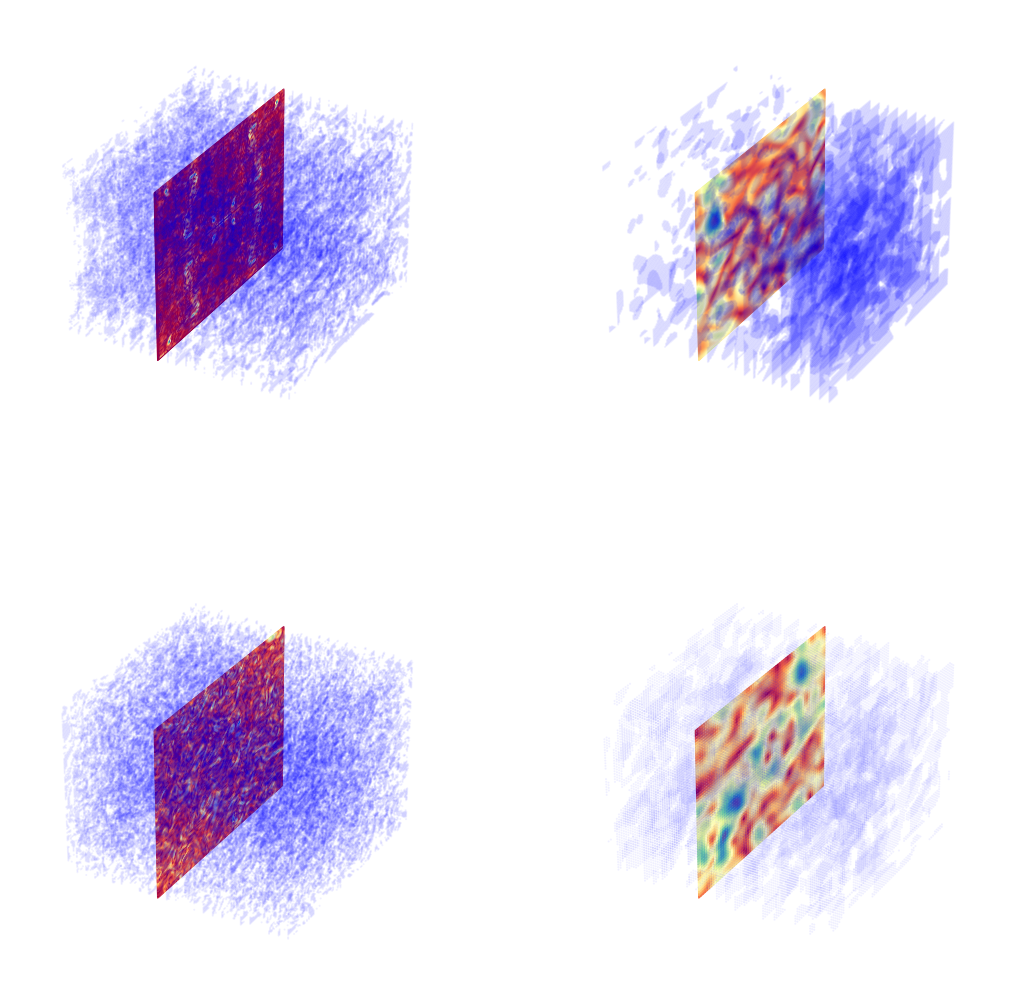

In [32]:
fig = plt.figure(figsize=(6.4*2, 6.4*2)) #, dpi=100

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
plot_3D(amplitudes_slice_128_TG_1800, selected_slice=10, color_map='Spectral',
        alpha_scater=0.05, ax=ax1)

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
plot_3D(amplitudes_slice_128_WN_20, selected_slice=10, color_map='Spectral',
        alpha_scater=0.05, ax=ax2)

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
plot_3D(amplitudes_slice_128_WN_1800, selected_slice=10, color_map='Spectral',
        alpha_scater=0.05, ax=ax3)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
plot_3D(np.array(amplitudes_slice_64_MHD_ERICO), selected_slice=10, color_map='Spectral',
        alpha_scater=0.05, ax=ax4)


# Exp 1. Verificar isotropia com medidas de entropia

In [65]:
''' BKP OLD
# Aqui estamos carregando todos os aquivos .npy que esta em uma das pastas
# baixadas. Dessa forma realizaremos uma recorrencia na analise
folder = "/content/" + "Taylor-Green_re_1800_grid_128_data_vorticity" #folders[5]
npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]
npy_files
# # Ordenar pela parte numérica
npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[2].split('.')[0]))
npy_file = npy_files[-1]

data_dict = {}
for file_name in npy_files:
    data_dict[file_name] = np.load(os.path.join(folder, file_name))

# Agora data_dict[file_name] tem o array carregado correspondente

data = data_dict[npy_file]

amplitude = np.sqrt(np.sum(data**2, axis=0))  # Soma ao longo do eixo das componentes (x,y,z)

#Stride:
amplitude = amplitude[::2, ::2, ::2]

import matplotlib.pyplot as plt
framesX, framesY, framesZ = [],[],[]
#  Pega o slice central no eixo z
for x in range(len(amplitude)):
  frameX = amplitude[x, :, :]
  framesX.append(frameX)
  frameY = amplitude[:, x, :]
  framesY.append(frameY)
  frameZ = amplitude[:, :, x]
  framesZ.append(frameZ)
'''


In [127]:
# Importar dados:
#framesX = amplitudes_last_slice_TG_1800_yz
#framesY = amplitudes_last_slice_TG_1800_xz
#framesZ = amplitudes_last_slice_TG_1800_xy

#framesX = amplitudes_last_slice_WN_20_yz
#framesY = amplitudes_last_slice_WN_20_xz
#framesZ = amplitudes_last_slice_WN_20_xy

framesX = amplitudes_last_slice_WN_1800_yz
framesY = amplitudes_last_slice_WN_1800_xz
framesZ = amplitudes_last_slice_WN_1800_xy

framesX

array([[[1.55185533, 1.75381929, 2.46807032, ..., 1.47718949,
         3.72216599, 1.81558316],
        [1.20844898, 2.50667723, 1.02532403, ..., 4.47043306,
         2.75753861, 2.81517811],
        [0.92736236, 1.48120202, 2.26805251, ..., 3.16148515,
         3.21586752, 1.55708301],
        ...,
        [1.11373909, 1.32941264, 1.27346096, ..., 6.6440062 ,
         6.75907538, 3.41076378],
        [1.72051409, 2.00845332, 0.96329857, ..., 5.40239147,
         5.20091059, 3.06032403],
        [2.43345055, 1.29921678, 1.58728304, ..., 2.62495124,
         2.98146677, 2.40789241]],

       [[2.27911428, 1.08061592, 2.79246414, ..., 2.69695511,
         2.89795449, 1.29917009],
        [2.09290633, 2.22988688, 5.0745359 , ..., 2.96716447,
         1.43363045, 2.51810774],
        [1.91449156, 3.7243481 , 6.00114462, ..., 2.92475438,
         1.72951481, 2.19260429],
        ...,
        [0.45057904, 1.27075844, 2.07740625, ..., 5.18700483,
         4.77129182, 1.24885978],
        [1.2

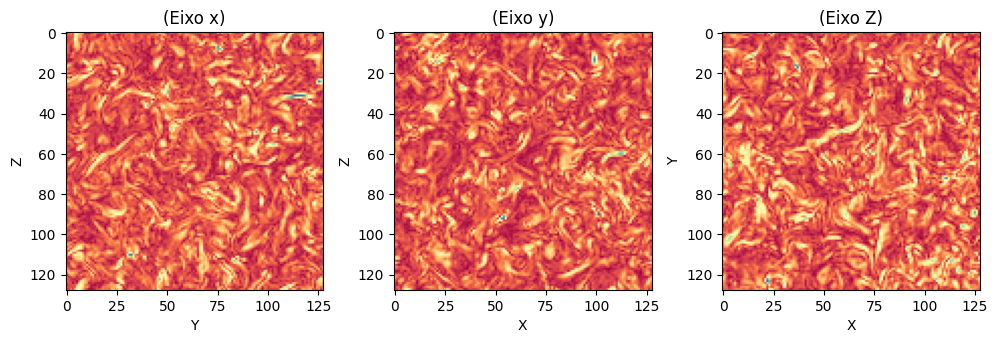

In [128]:
#Visualizar alguns frames:
frame = -1
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(framesX[frame], cmap='Spectral')  # Você pode mudar o cmap se quiser
# plt.colorbar(label='Amplitude')
plt.title('(Eixo x)')
plt.xlabel('Y')
plt.ylabel('Z')

plt.subplot(1, 3, 2)
plt.imshow(framesY[frame], cmap='Spectral')  # Você pode mudar o cmap se quiser
# plt.colorbar(label='Amplitude')
plt.title('(Eixo y)')
plt.xlabel('X')
plt.ylabel('Z')

plt.subplot(1, 3, 3)
plt.imshow(framesZ[frame], cmap='Spectral')  # Você pode mudar o cmap se quiser
# plt.colorbar(label='Amplitude')
plt.title('(Eixo Z)')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

In [129]:
# Calcular entropias
dataset = [df_entropys(framesX, GPA=False),
           df_entropys(framesY, GPA=False),
           df_entropys(framesX, GPA=False)]

#paramentros
colors = ['red', 'green', 'blue']
class_names = ['X', 'Y', 'Z']

100%|██████████| 128/128 [00:35<00:00,  3.63it/s]


In [133]:
# Printar tabela em latex:
print(gerar_tabela_latex(dataset, colors, round_media=3, round_std=3))

\begin{table}[!ht]\label{tab:dataset}
\caption{}
  \begin{center}
    \begin{tabular}{l c c c}
      \hline
\textbf{d} & \textbf{red}  & \textbf{green}  & \textbf{blue} \\ \midrule
$S^h_H$ & 0.87 ± 0.014 & 0.868 ± 0.013 & 0.87 ± 0.014\\
$S^p_H$ & 0.995 ± 0.0 & 0.995 ± 0.0 & 0.995 ± 0.0\\
$S^s_H$ & 0.853 ± 0.005 & 0.853 ± 0.006 & 0.853 ± 0.005\\
$S^h_q$ & -1.841 ± 0.005 & -1.84 ± 0.005 & -1.841 ± 0.005\\
$S^p_q$ & -1.942 ± 0.0 & -1.942 ± 0.0 & -1.942 ± 0.0\\
$S^s_q$ & -1.905 ± 0.002 & -1.905 ± 0.002 & -1.905 ± 0.002\\
      \hline
    \end{tabular}
  \end{center}
\end{table}


('Histogram_PowerlawTsallis', 'Histogram_Shannon') with score -7.540440068458905e-06


<Figure size 1500x1200 with 0 Axes>

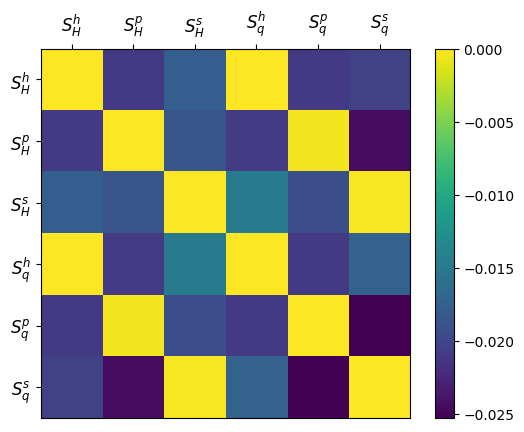

In [130]:
# Score de silhueta
plt.figure(figsize=(5,4),dpi=300)
scores = silhouette_score(dataset, prin_best_correlation=True)
plot_silhouette_score(scores,cmap="viridis")
# plt.savefig('Silhueta.pdf')
plt.show()

<ipython-input-131-9a2bfe077c7d>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


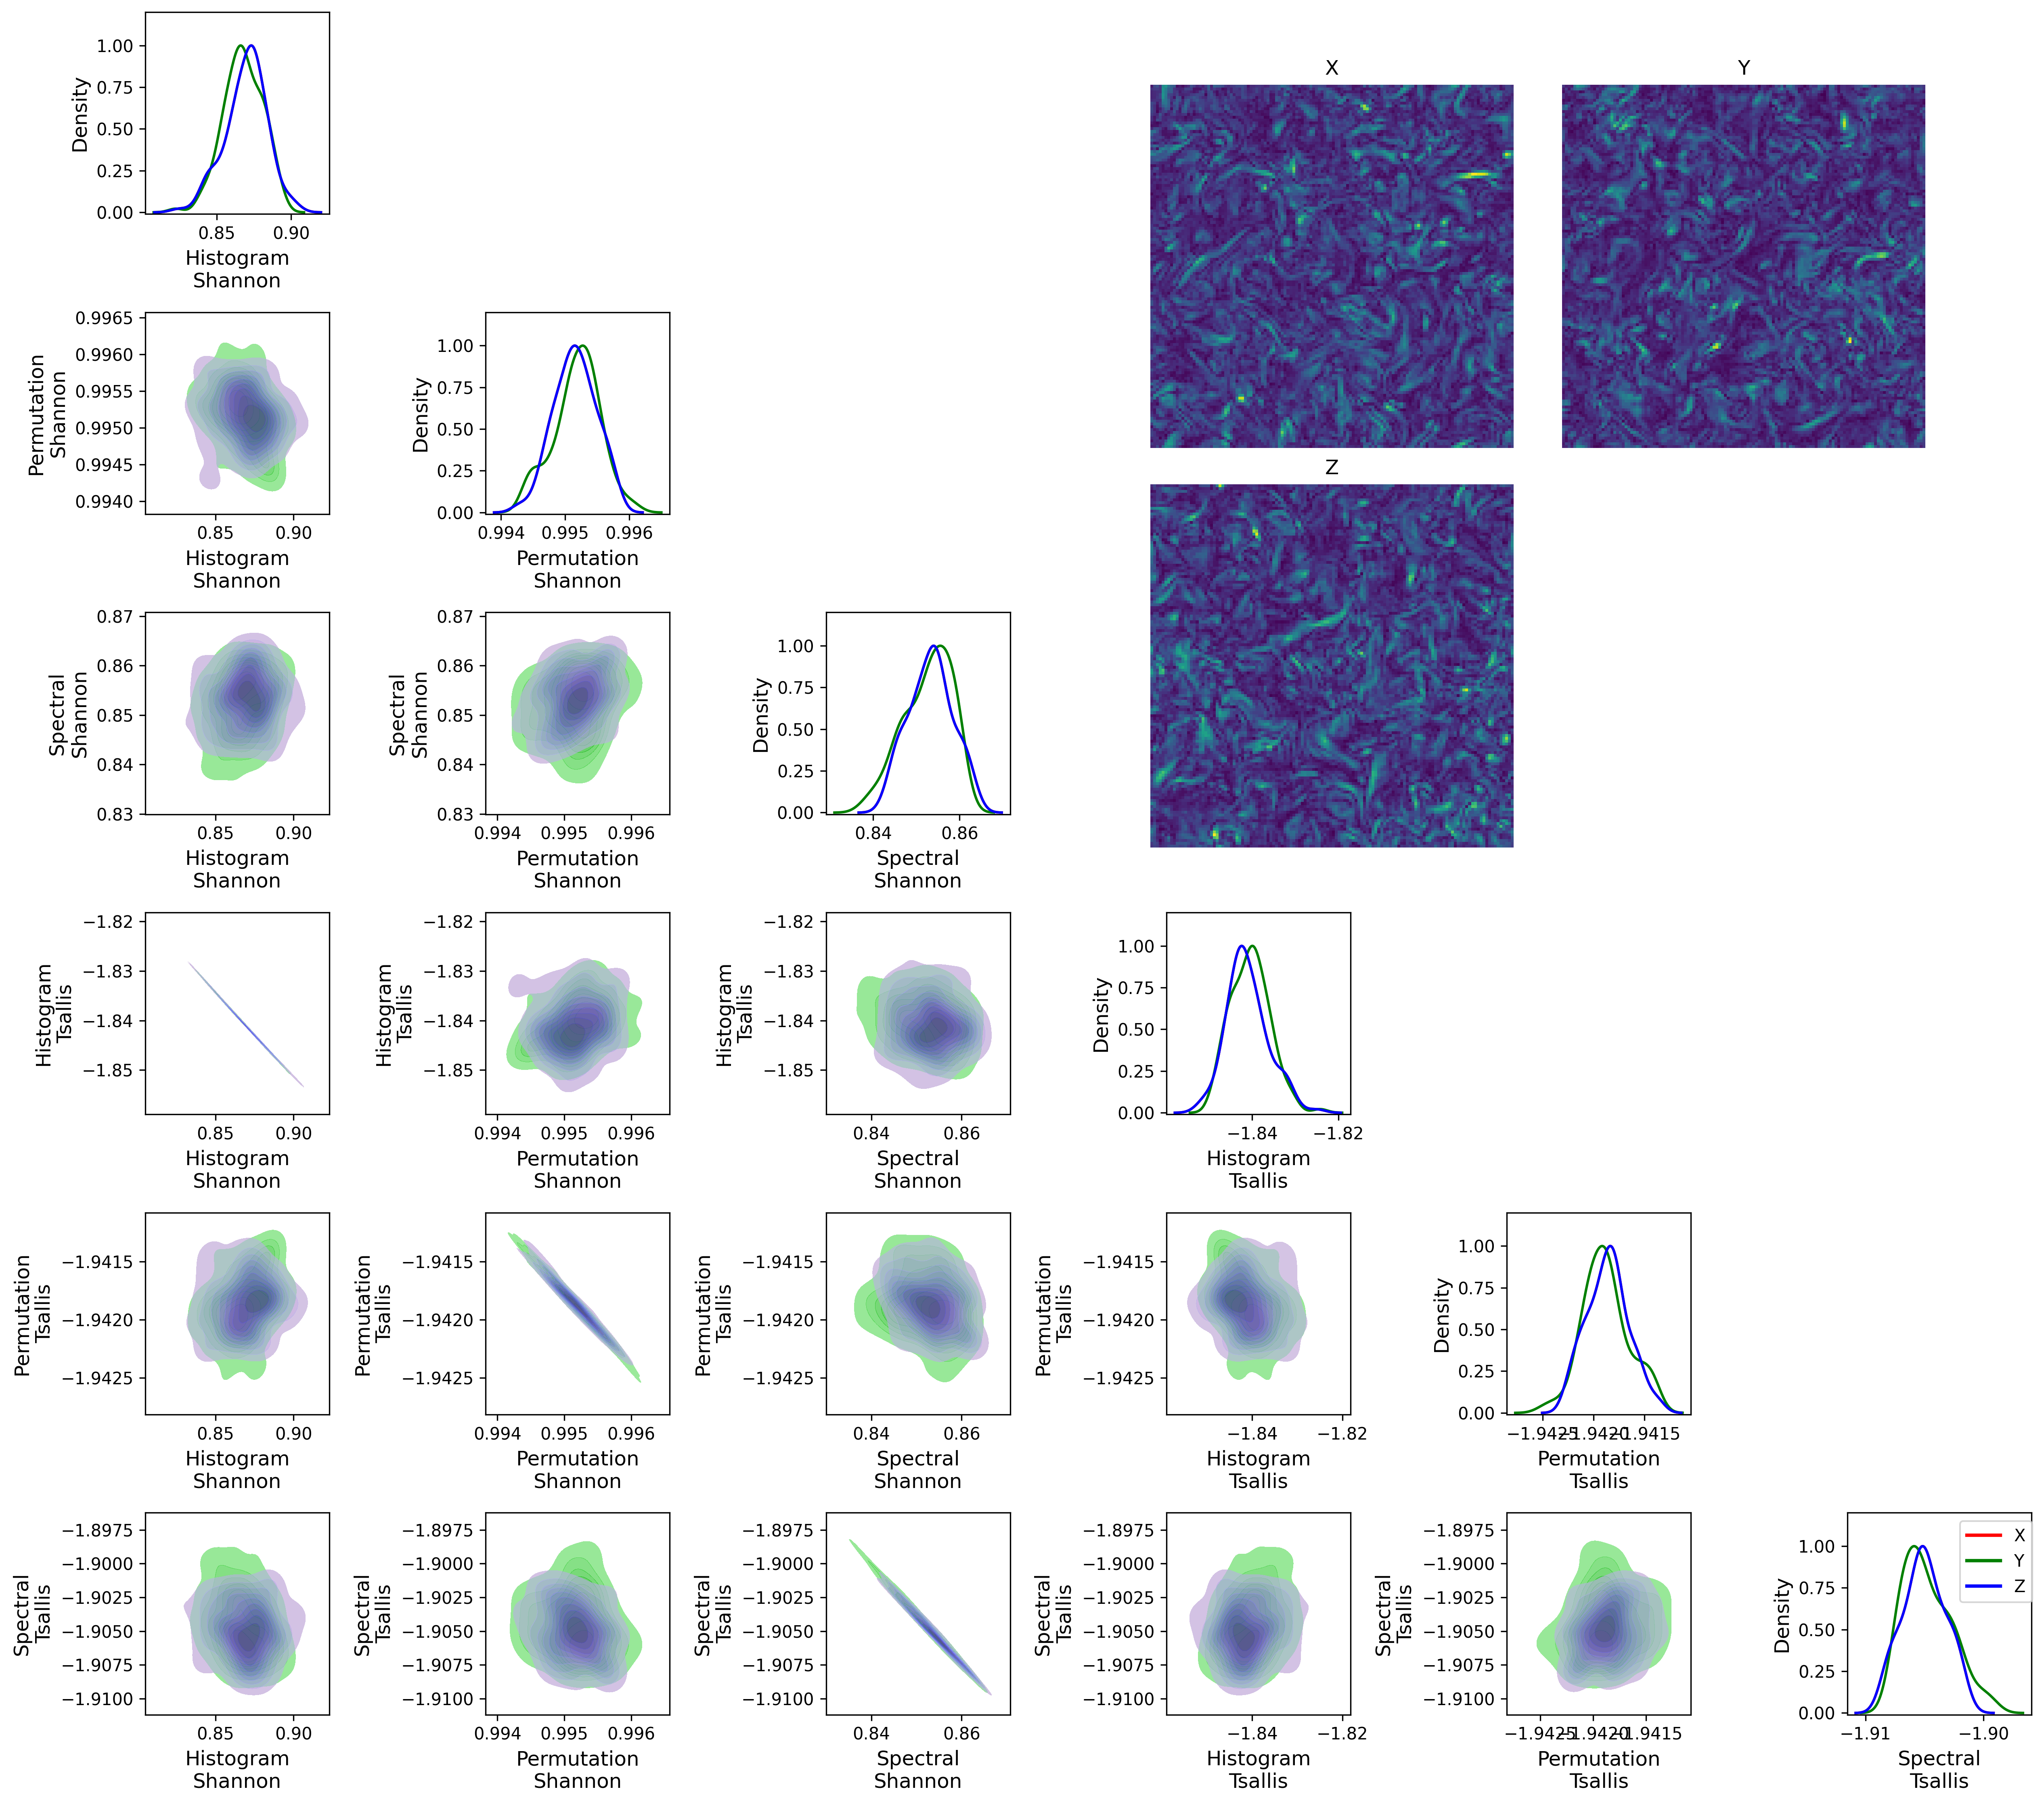

In [131]:
frames = [framesX, framesY, framesZ]

fig = plt.figure(figsize=(17, 15), dpi=300)
fontsize = 12

triangle_kdeplot(dataset,colors,
                 class_names=class_names,
                 fontsize=fontsize,
                 fill =True, alpha = 0.6)

# Inserir imagens na parte inferior da figura
img_positions = [(0.55, .75), (0.75, .75), (0.55, .53),  (0.75, .53)]
Width, Height = 0.2, 0.2
for k in range(len(frames)):
    ax_img = fig.add_axes([img_positions[k][0], img_positions[k][1], Width, Height])
    ax_img.imshow(frames[k][-1])
    ax_img.set_title(class_names[k], fontsize=fontsize)
    ax_img.axis('off')

plt.tight_layout()
# save_imagens_path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.png', dpi=100)
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.pdf', dpi=300)
plt.show()

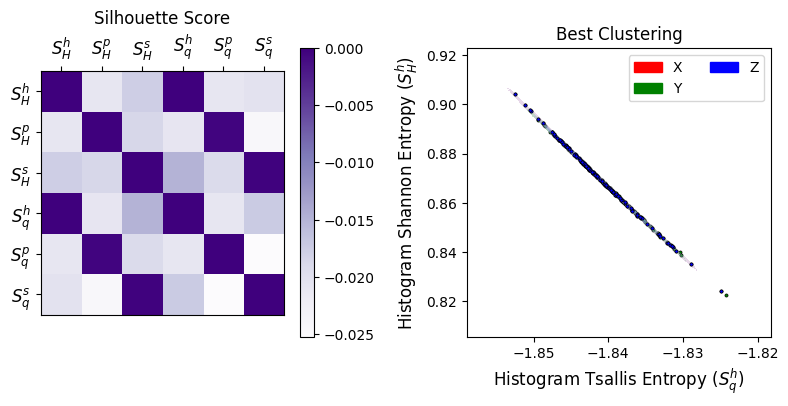

In [134]:
# Triangle plot:
plt.figure(figsize=(8, 4)) #, dpi=300

ax1 = plt.subplot(1, 2, 1)
plot_silhouette_score(scores, ax=ax1, cmap='Purples')
ax1.set_title("Silhouette Score")

ax2 = plt.subplot(1, 2, 2)
plot_one_pair(dataset, ax=ax2,
              colors=colors,
              class_names=class_names, fontsize=12)#, names_x=names_x, names_y=names_y)
ax2.set_title("Best Clustering")
plt.tight_layout()

# plt.savefig(f'{save_path}Silhueta.pdf',dpi=300)
# plt.savefig(f'{save_path}Silhueta.png',dpi=100)

plt.show()

# Exp 2. MHD (erico) vs Hidrodinamica

## Data

### Load Data - Hidro
Observe que o dado ja foi minerado na sessão anterior

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

folder = "/content/" + "Wavenumber_forcing_456_re_20_grid=128_data_velocity" #folders[5]

def read_files(folder,n_files=None):

  npy_files = [f for f in os.listdir(folder) if f.endswith('.npy')]
  try:
    npy_files = sorted(npy_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
  except:
    pass
  if n_files is not None:
    last_files = npy_files[-n_files:]
  else:
    last_files = npy_files
  final_slices = []

  for file_name in last_files:
      data = np.load(os.path.join(folder, file_name))  # shape ex: (3,128,128) ou (3,128,128,128)

      amplitude = np.sqrt(np.sum(data**2, axis=0))  # shape (128,128)

      # Selecionar 11 fatias equidistantes no eixo 0 (tempo/profundidade)
      num_slices = 11
      axis0_size = amplitude.shape[0]
      indices = np.linspace(0, axis0_size - 1, num_slices).astype(int)

      selected_slices = amplitude[indices, :, :]  # (11,128,128)

      # Downsampling 2x nas dimensões XY
      downsampled = selected_slices[:, ::2, ::2]  # (11,64,64)

      final_slices.append(downsampled)

  # Concatenar fatias dos 6 arquivos (total 66 fatias)
  hidro_data_cube = np.concatenate(final_slices, axis=0)  # (66,64,64)
  return hidro_data_cube


TG1800 = read_files('/content/Taylor-Green_re_1800_grid_128_data_vorticity',n_files=6)
wf456_r1800 = read_files("/content/Wavenumber_forcing_456_re_1800_grid_128_data_vorticity",n_files=6)
Wf456_r20 = read_files("/content/Wavenumber_forcing_456_re_20_grid=128_data_velocity",n_files=6)

# hidro_data_cube = read_files(folders[0],n_files=6)
hidro_data_cube = TG1800
# Reduzir para 64 fatias
# hidro_data_cube = data_cube[:64, :, :]  # (64,64,64)

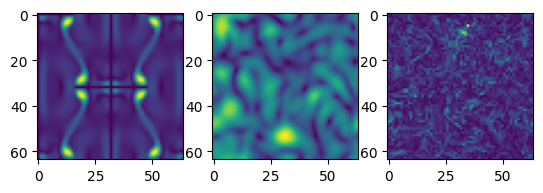

In [ ]:
plt.subplot(1,3,1)
plt.imshow(TG1800[32],cmap='viridis')
plt.subplot(1,3,2)
plt.imshow(Wf456_r20[32],cmap='viridis')
plt.subplot(1,3,3)
plt.imshow(wf456_r1800[32],cmap='viridis')

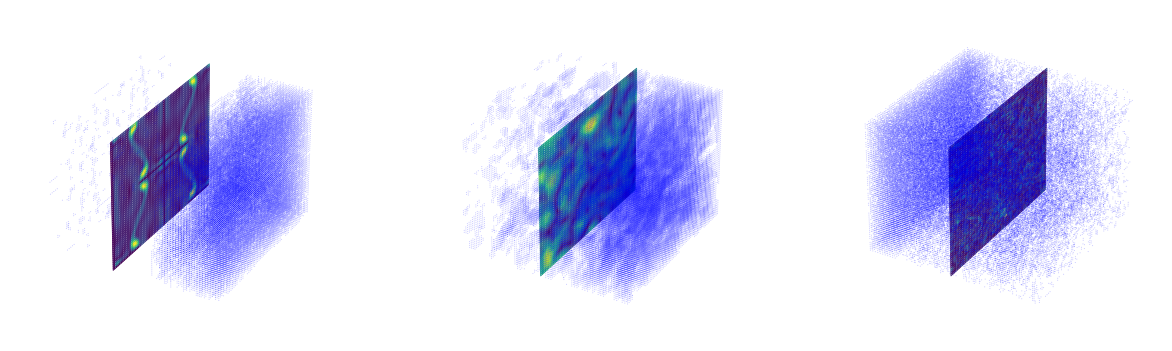

In [ ]:
fig = plt.figure(figsize=(30, 10),dpi=50)
ax1 = fig.add_subplot(1,3 , 1, projection='3d')
ax2 = fig.add_subplot(1,3 , 2, projection='3d')
ax3 = fig.add_subplot(1,3 , 3, projection='3d')

plot_3D(TG1800,ax=ax1,selected_slice=32)
plot_3D(Wf456_r20,ax=ax2,selected_slice=32)
plot_3D(wf456_r1800,ax=ax3,selected_slice=32)


## Pré-processing

**Continuar refatorando a partir daqui!!!**

In [28]:
'''
raw_data = [TG1800,
            Wf456_r20,
            wf456_r1800,
            mhd_data_cube,
            # Adicione aqui o cubo de sua prefência
            ]
'''

raw_data = [amplitudes_slice_64_TG_1600,
            amplitudes_slice_64_WN_20,
            amplitudes_slice_64_WN_1800,
            amplitudes_slice_64_MHD_ERICO
            ]

dataset = []
for data in raw_data:
  dataset.append(df_entropys(data,GPA=False))

sup_title = "Hidro vs MHD"
colors = ['green','red','blue','violet']
class_names = ['TG1600','Wf456_r20','wf456_r1800', 'MHD']
color_maps = []

100%|██████████| 25/25 [00:02<00:00, 11.41it/s]


## Results

### Tabela Latex

In [29]:
print(gerar_tabela_latex(dataset, class_names,round_media=3, round_std=3))

\begin{table}[!ht]\label{tab:dataset}
\caption{}
  \begin{center}
    \begin{tabular}{l c c c c}
      \hline
\textbf{d} & \textbf{TG1800}  & \textbf{Wf456_r20}  & \textbf{wf456_r1800}  & \textbf{MHD} \\ \midrule
$S^h_H$ & 0.889 ± 0.015 & 0.926 ± 0.014 & 0.918 ± 0.01 & 0.936 ± 0.014\\
$S^p_H$ & 0.988 ± 0.007 & 0.894 ± 0.011 & 0.999 ± 0.0 & 0.895 ± 0.005\\
$S^s_H$ & 0.543 ± 0.081 & 0.555 ± 0.04 & 0.847 ± 0.011 & 0.564 ± 0.017\\
$S^h_q$ & -1.783 ± 0.006 & -1.797 ± 0.005 & -1.794 ± 0.004 & -1.8 ± 0.005\\
$S^p_q$ & -1.881 ± 0.005 & -1.838 ± 0.009 & -1.909 ± 0.0 & -1.838 ± 0.004\\
$S^s_q$ & -1.677 ± 0.076 & -1.713 ± 0.035 & -1.86 ± 0.005 & -1.725 ± 0.014\\
      \hline
    \end{tabular}
  \end{center}
\end{table}


### Score de Silueta

('Spectral_Shannon', 'Histogram_Shannon') with score 0.24756685291113556


<Figure size 1500x1200 with 0 Axes>

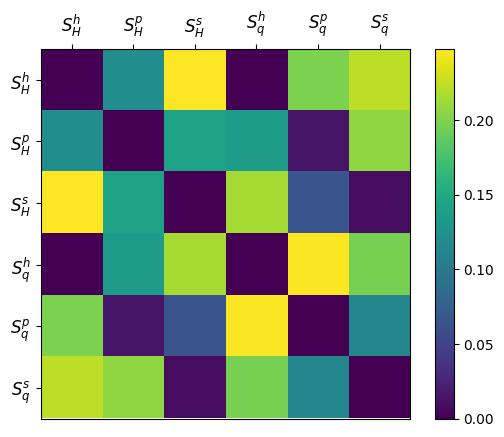

In [30]:
plt.figure(figsize=(5,4),dpi=300)
scores = silhouette_score(dataset,prin_best_correlation=True)
plot_silhouette_score(scores,cmap="viridis")
# plt.savefig('Silhueta.pdf')
plt.show()

### Triangle Plot

<ipython-input-34-33fddeea5113>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


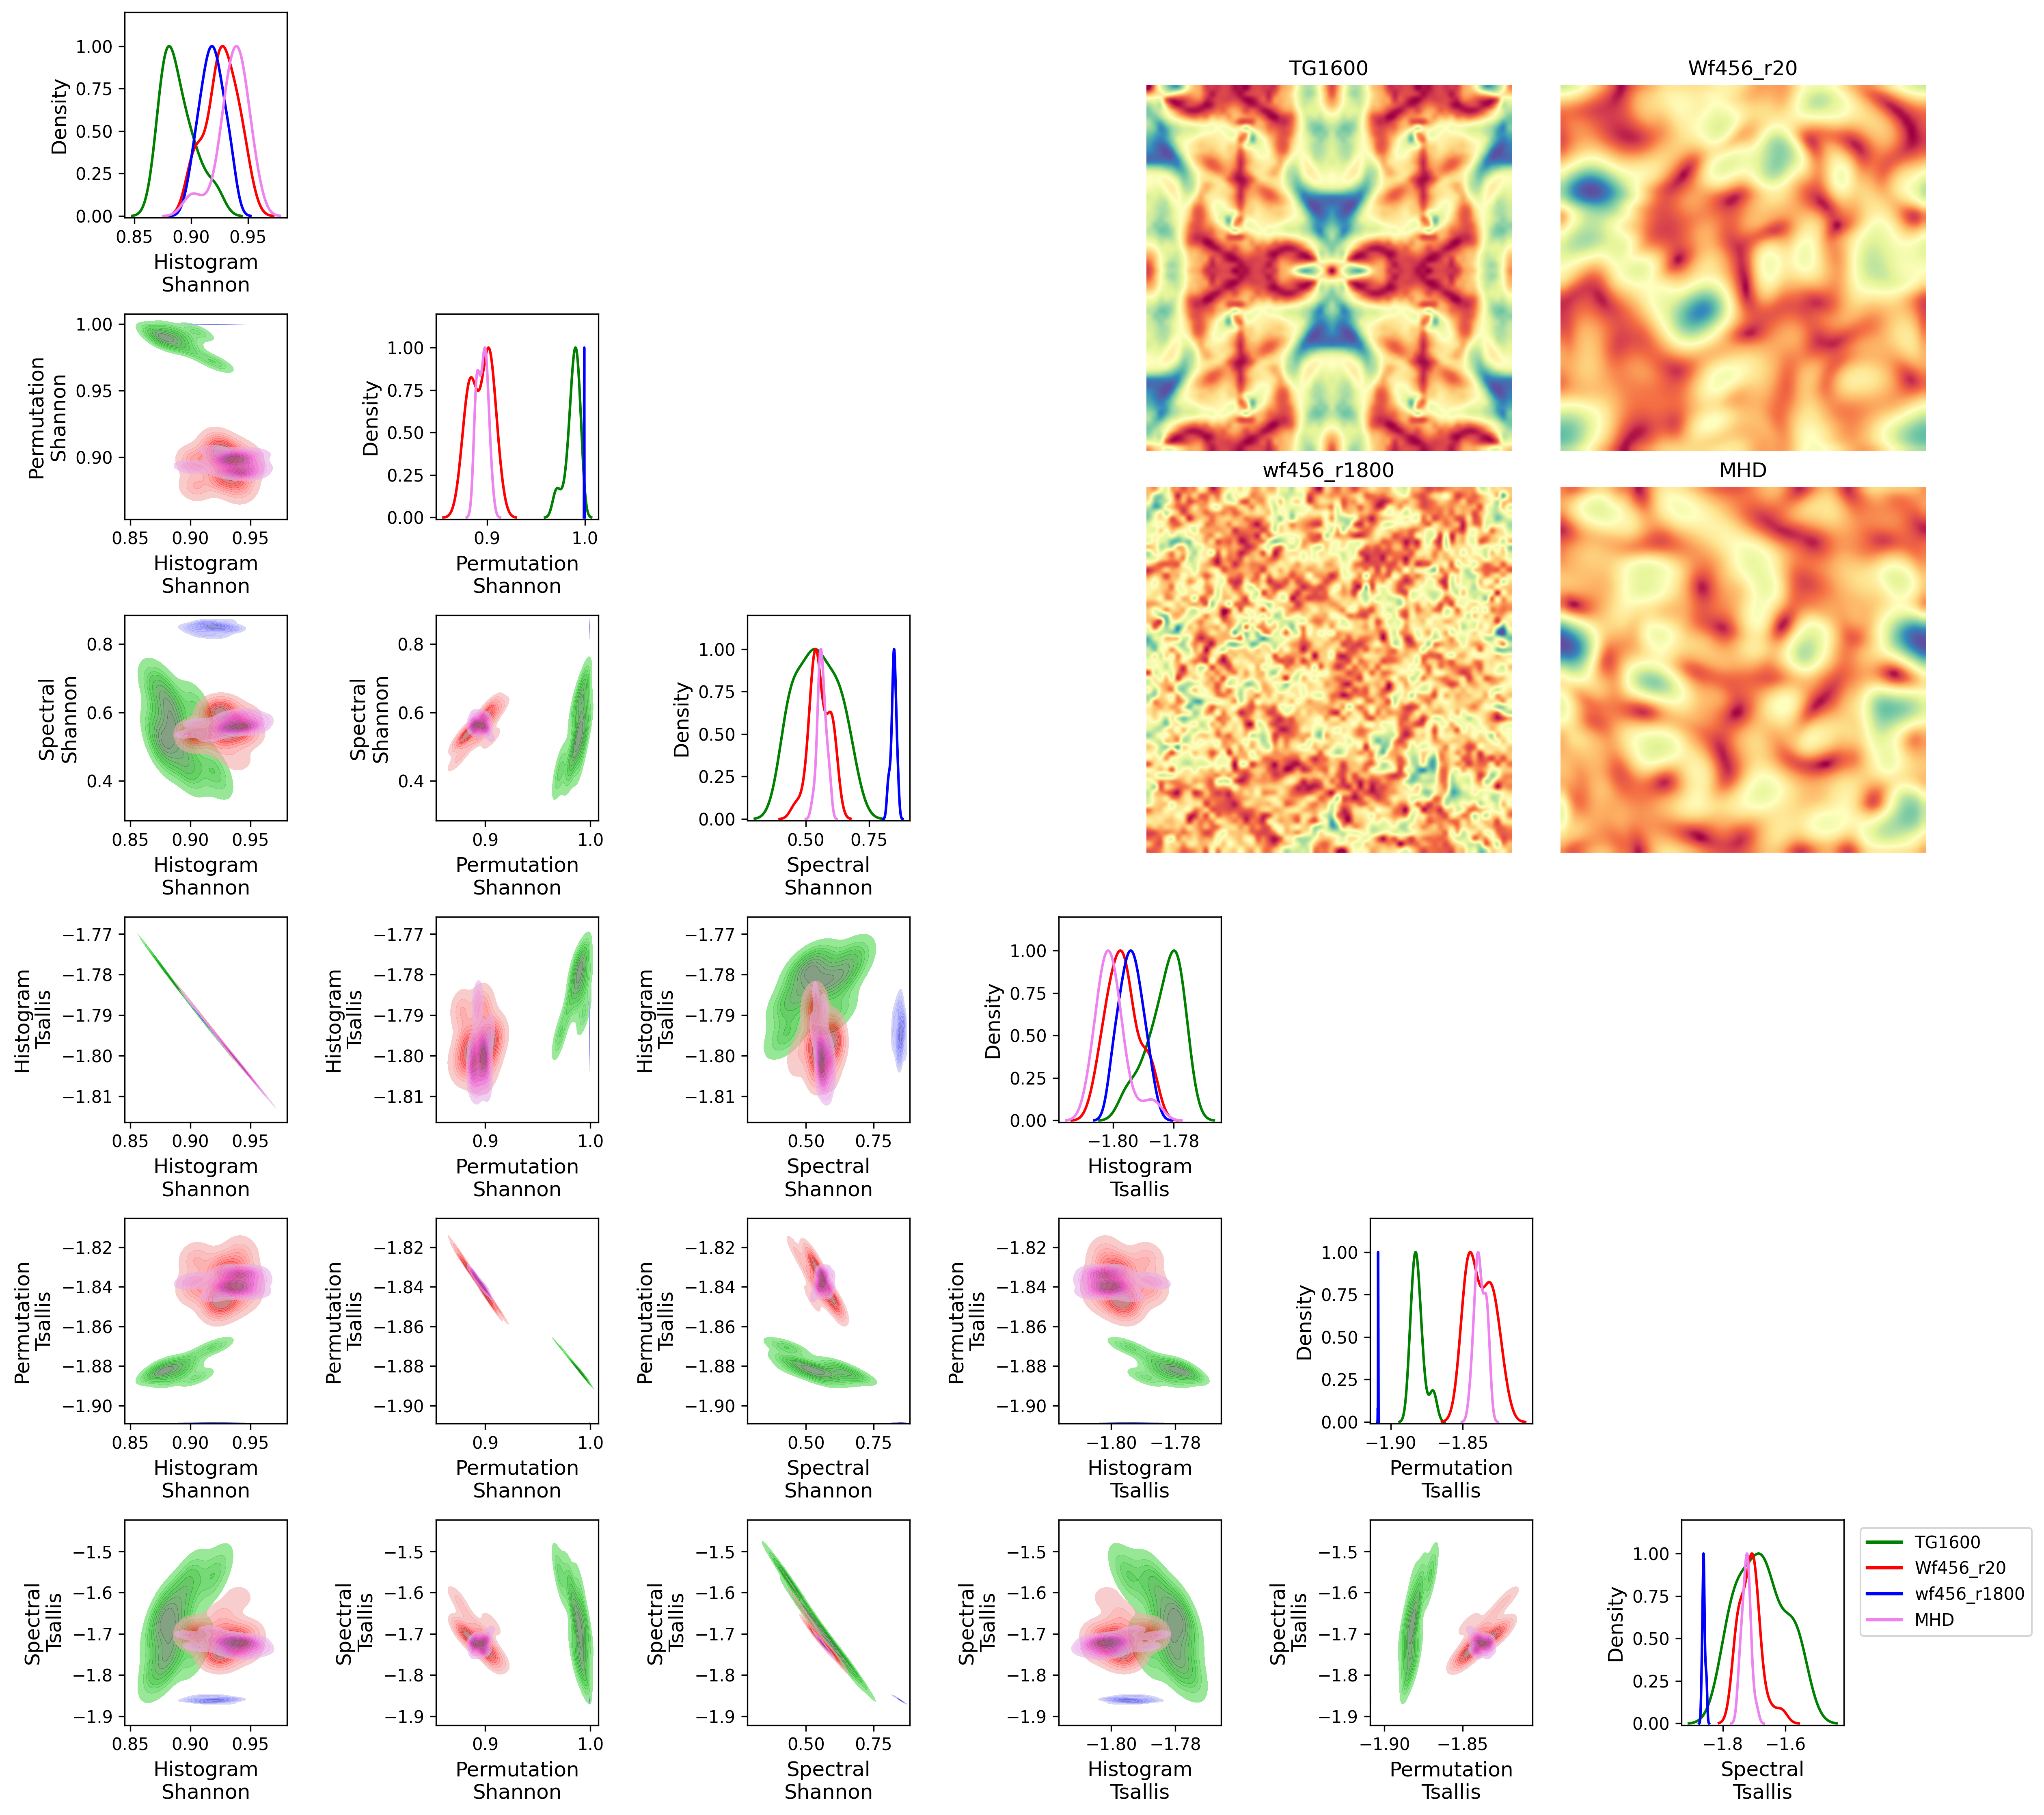

In [34]:
fig = plt.figure(figsize=(17, 15), dpi=300)
fontsize = 12

triangle_kdeplot(dataset,colors,
                 class_names=class_names,
                 fontsize=fontsize,
                 fill =True, alpha = 0.6)

# Inserir imagens na parte superior direita da figura
img_positions = [(0.55, .75), (0.75, .75), (0.55, .53),  (0.75, .53)] #posições das imagens. Setado incialmente para caber 4 figuras. Se quiser colocar mais tem que ajustar o tamanho
Width, Height = 0.2, 0.2
for k in range(len(raw_data)):
    ax_img = fig.add_axes([img_positions[k][0], img_positions[k][1], Width, Height])
    ax_img.imshow(raw_data[k][-1], interpolation='spline16', cmap='Spectral')
    ax_img.set_title(class_names[k], fontsize=fontsize)
    ax_img.axis('off')

plt.tight_layout()
# save_imagens_path = "/home/barauna/MEGA/Academia/DOUTORADO/Tese/figuras/"
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.png', dpi=100)
# plt.savefig(f'{save_imagens_path}triangle_KDEioxies.pdf', dpi=300)
plt.show()

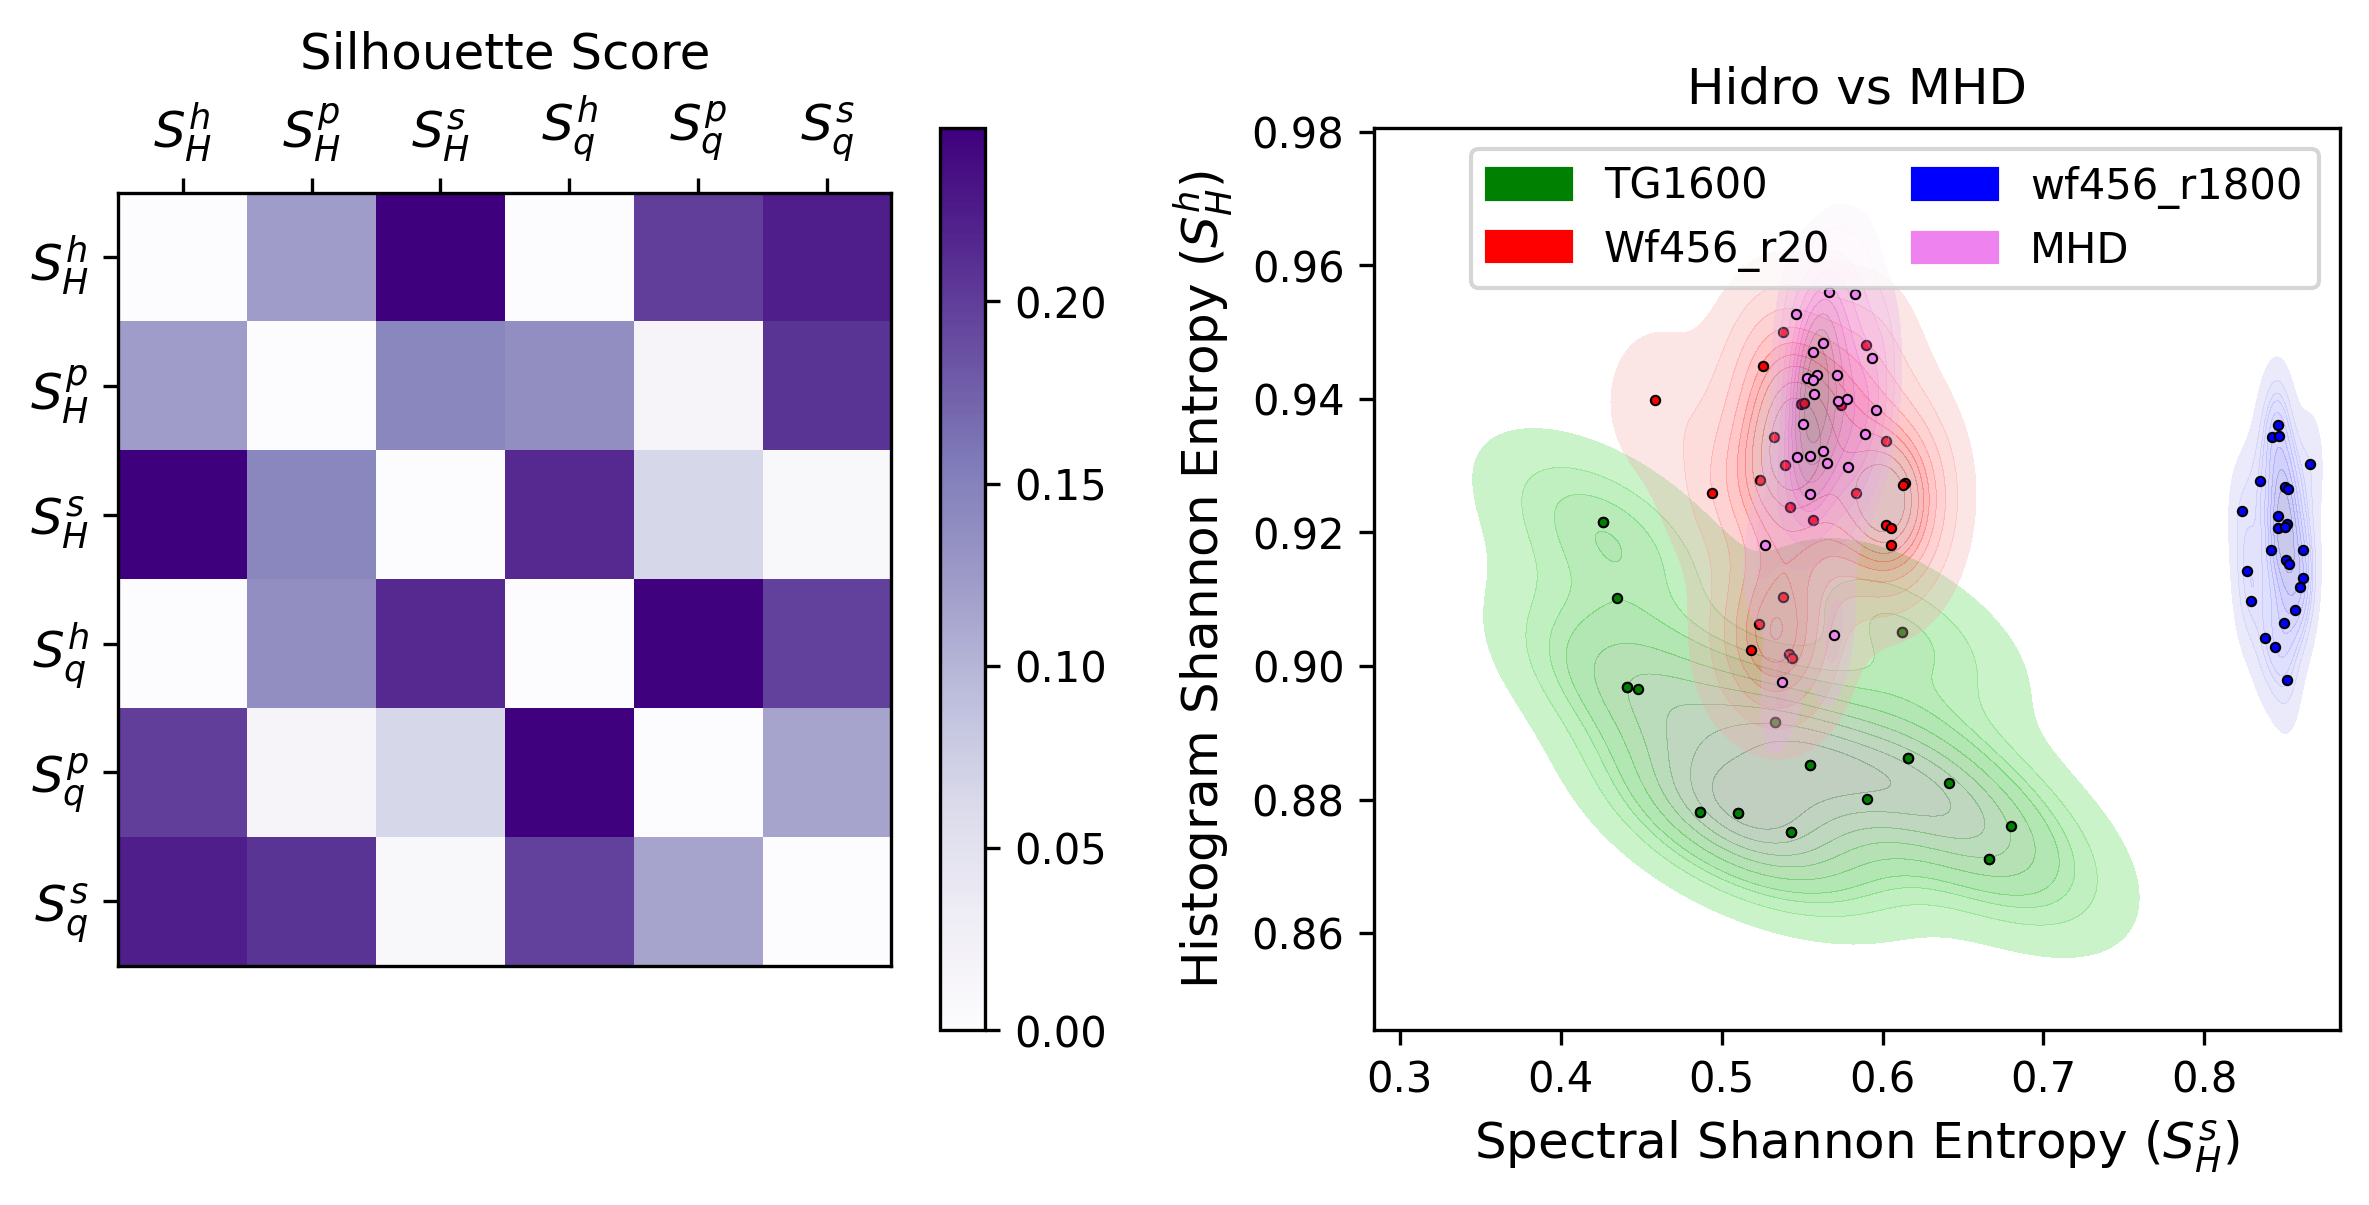

In [35]:
plt.figure(figsize=(8, 4), dpi=300)

ax1 = plt.subplot(1, 2, 1)
plot_silhouette_score(scores, ax=ax1, cmap='Purples')
ax1.set_title("Silhouette Score")

ax2 = plt.subplot(1, 2, 2)
plot_one_pair(dataset, ax=ax2,
              colors=colors,
              class_names=class_names, fontsize=12)#, names_x=names_x, names_y=names_y)
ax2.set_title(sup_title)
plt.tight_layout()

# plt.savefig(f'{save_path}Silhueta.pdf',dpi=300)
# plt.savefig(f'{save_path}Silhueta.png',dpi=100)

plt.show()